# Week 4: Interpretable Machine Learning for Data Science

**Problem**: You have been mandated by a large wine-making company in Valais to discover the key chemical factors that determine the quality of wine and build an interpretable model that will help their cellar masters make decisions daily.

## Settings things up (15')

This week will require quite a lot of autonomy on your part, but we will guide you with this high-level notebook. First, take the following steps:

- Install [Poetry](https://python-poetry.org). 
- Then use Poetry to create a virtual environment:

  ```sh
  poetry install
  ```

- Then restart VS Code and add the kernel that corresponds to the environment created by Poetry.

Then, let's set up [black](https://github.com/psf/black), which is a highly encouraged best-practice for all your Python projects. That way, you never have to worry and debate about code formatting anymore. By using it, you agree to cede control over minutiae of hand-formatting. In return, Black gives you speed, determinism, and freedom from `pycodestyle` nagging about formatting. You will save time and mental energy for more important matters.

In [230]:
import jupyter_black

jupyter_black.load()

Here are the libraries you will most likely need and use during this week:

- `numpy` for basic scientific computing and `scipy` for statistical testing.
- `pandas` or `polars` for dataset manipulation. Polars is highly recommended, because it is [awesome](https://github.com/ddotta/awesome-polars). Instructions below will refer to the Polars API.
- `seaborn` for statistical data visualization, but `matplotlib` is always needed anyway. Use both!
- `shap` will be used for [interpretability](https://shap.readthedocs.io/en/stable/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).
- `sklearn` and `xgboost` will be used for training models. You may import them later when you need them.

## Fetch the data (15')

Here we have a very nice package that can do everything for us (aka `ucimlrepo`). Let's use it!

Take a look at [the website](https://archive.ics.uci.edu/dataset/186/wine+quality) for details.

In [231]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Fetch the Wine Quality dataset
wine_quality_data = fetch_ucirepo(id=186)  # 186 is the dataset ID for wine quality

# Extract the features (data) and labels (target)
X = wine_quality_data.data.features  # Feature matrix
y = wine_quality_data.data.targets  # Target labels
color = wine_quality_data.data.original["color"]

# Create a DataFrame for the features
feature_names = wine_quality_data.data.feature_names  # Get feature names
X_df = pd.DataFrame(X, columns=feature_names)

# Create a DataFrame for the target (quality) and color
y_df = pd.DataFrame(y, columns=["quality"])
color_df = pd.DataFrame(color, columns=["color"])

# Combine the features, target, and color into one DataFrame
wine_df = pd.concat([X_df, y_df, color_df], axis=1)

In [232]:
X = wine_df
X

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


In [233]:
y = wine_df["quality"]
y

0       5
1       5
2       5
3       6
4       5
       ..
6492    6
6493    5
6494    6
6495    7
6496    6
Name: quality, Length: 6497, dtype: int64

Now, let's check that the data have the correct shape to ensure they have been loaded as expected.

Calculate how many samples and features we have in total, how many are red or white wines, how many are good or bad wines, etc.

In [234]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(drop="first", sparse_output=False)

encoded_data = onehot_encoder.fit_transform(X[["color"]])

encoded_df = pd.DataFrame(
    encoded_data, columns=onehot_encoder.get_feature_names_out(["color"])
)

wine_df_encoded = pd.concat([X.drop(["color"], axis=1), encoded_df], axis=1)

wine_df_encoded

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1.0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,1.0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1.0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1.0


In [235]:
n_samples, n_features = X_df.shape
print(f"Number of samples: {n_samples}")
print(f"Number of features: {n_features}")

Number of samples: 6497
Number of features: 11


In [236]:
# Complete this cell with your code
print("\nFirst 11 feature rows:\n", X[:15])
print("\nFirst target values:\n", y[:2])


First 11 feature rows:
     fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0             7.4             0.700         0.00             1.9      0.076   
1             7.8             0.880         0.00             2.6      0.098   
2             7.8             0.760         0.04             2.3      0.092   
3            11.2             0.280         0.56             1.9      0.075   
4             7.4             0.700         0.00             1.9      0.076   
5             7.4             0.660         0.00             1.8      0.075   
6             7.9             0.600         0.06             1.6      0.069   
7             7.3             0.650         0.00             1.2      0.065   
8             7.8             0.580         0.02             2.0      0.073   
9             7.5             0.500         0.36             6.1      0.071   
10            6.7             0.580         0.08             1.8      0.097   
11            7.5          

## Data Exploration (1h30)

We now will inspect the features one-by-one, and try to understand their dynamics, especially between white and red wines.

- Use `Dataframe.describe` to display statistics on each feature. Do the same for red wines only, and white wines only. Do you notice any clear difference?
- Compute the effect size by computing the [strictly standardized mean difference](https://en.wikipedia.org/wiki/Strictly_standardized_mean_difference) (SSMD) between the red and white wines for each feature. 

Here’s a more visually pleasant markdown format for the feature explanations:

---

### 1. **Fixed Acidity**
- **Definition**: Non-volatile acids present in wine that do not evaporate during fermentation (e.g., tartaric, malic, citric acids).
- **Importance**: Contributes to the tartness or sourness of wine. Higher levels result in a more acidic, crisp taste. Ideal levels depend on the wine's style and balance.

---

### 2. **Volatile Acidity**
- **Definition**: Acids that can evaporate, primarily acetic acid (vinegar).
- **Importance**: Adds complexity at low levels, but at high levels, it’s considered a fault, giving a vinegary taste.

---

### 3. **Citric Acid**
- **Definition**: One of the fixed acids, usually found in small amounts. It can be added to increase acidity.
- **Importance**: Provides freshness and a zesty flavor, but too much can lead to a sour taste.

---

### 4. **Residual Sugar**
- **Definition**: The sugar remaining after fermentation, determining whether the wine is dry, off-dry, or sweet.
- **Importance**: Affects sweetness and balance. Higher levels indicate sweeter wines, while low levels produce dry wines.

---

### 5. **Chlorides**
- **Definition**: Chloride ions present in wine, originating from salt.
- **Importance**: Contributes to wine's salinity, which can enhance flavor. Too much can be undesirable, but a small amount may improve taste, especially in white wines.

---

### 6. **Free Sulfur Dioxide (SO₂)**
- **Definition**: The active portion of sulfur dioxide that protects wine from oxidation and microbial spoilage.
- **Importance**: Acts as an antioxidant and antimicrobial agent. Essential for stability but can negatively affect aroma and flavor if overused.

---

### 7. **Total Sulfur Dioxide (SO₂)**
- **Definition**: The total amount of sulfur dioxide, including both free and bound forms.
- **Importance**: While necessary for preservation, too much can lead to a pungent smell, affecting the wine’s sensory quality.

---

### 8. **Density**
- **Definition**: The density of wine compared to water, often linked to sugar and alcohol content.
- **Importance**: Indicates sugar or alcohol levels. Useful for tracking fermentation progress.

---

### 9. **pH**
- **Definition**: A measure of acidity or basicity. Lower pH means higher acidity.
- **Importance**: Influences stability, color, taste, and microbial activity. Red wines usually have a higher pH than white wines.

---

### 10. **Sulphates**
- **Definition**: Sulfate compounds (e.g., potassium sulfate) used as antioxidants and preservatives.
- **Importance**: Helps stabilize and preserve freshness. Excess can add bitterness, but controlled levels are beneficial.

---

### 11. **Alcohol**
- **Definition**: The ethanol content in wine, typically between 8% and 15% ABV (Alcohol by Volume).
- **Importance**: Influences body, flavor, and mouthfeel. Higher alcohol gives warmth and richness, while lower alcohol makes wine lighter and fresher.

---

### 12. **Quality**
- **Definition**: A subjective sensory rating of wine quality, usually on a scale from 0 to 10.
- **Importance**: Reflects taste, aroma, balance, and overall impression. Influenced by factors like alcohol, acidity, and residual sugar.

---

This layout offers a clean and structured explanation of each feature for better readability.

In [237]:
import numpy as np
import pandas as pd

In [238]:
df = pd.DataFrame(
    wine_quality_data.data.features, columns=wine_quality_data.feature_names
)
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


In [239]:
# CHECK IF DATASET IS BALANCED
color.value_counts()

color
white    4898
red      1599
Name: count, dtype: int64

In [240]:
white_wine_df = X[X["color"] == "white"]
white_wine_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
1599,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,white
1600,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,white
1601,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,white
1602,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,white
1603,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


In [241]:
red_wine_df = X[X["color"] == "red"]
red_wine_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,red
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,red
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,red
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,red


In [242]:
# Display descriptive statistics for red wines
print("Descriptive statistics for red wines:")
print(red_wine_df.describe())

Descriptive statistics for red wines:
       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       

In [243]:
# Display descriptive statistics for white wines
print("\nDescriptive statistics for white wines:")
print(white_wine_df.describe())


Descriptive statistics for white wines:
       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min    

Analysis:
- Fixed Acidity: Red wines tend to have higher fixed acidity compared to white wines.
- Volatile Acidity: Red wines have higher volatile acidity, indicating they might have a more pungent or sharper taste.
- Citric Acid: White wines have a higher citric acid content, which could contribute to a fresher taste.
- Residual Sugar: White wines generally contain much more residual sugar, making them sweeter than red wines.
- Chlorides: Red wines have a higher chloride content, which can contribute to a saltier taste.
- Free and Total Sulfur Dioxide: White wines contain significantly higher levels of sulfur dioxide, which helps preserve freshness and prevents oxidation.
- Density: Red wines tend to have slightly higher density, likely due to higher acidity and lower sugar content.
- pH: Red wines have slightly higher pH values, indicating they are marginally less acidic than white wines.
- Sulphates: Red wines have higher sulphate content, which may contribute to a sharper taste.
- Alcohol: Alcohol content is similar between the two, though white wines show slightly more variation.
- Quality: White wines have a slightly higher average quality rating but with similar variation in scores.

In [244]:
# Features to calculate SSMD for
features = [
    "fixed_acidity",
    "volatile_acidity",
    "citric_acid",
    "residual_sugar",
    "chlorides",
    "free_sulfur_dioxide",
    "total_sulfur_dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]

In [245]:
ssmd = {}

In [246]:
for feature in features:
    red_mean = red_wine_df[feature].mean()
    white_mean = white_wine_df[feature].mean()
    red_std = red_wine_df[feature].std()
    white_std = white_wine_df[feature].std()

    # Mean difference and combined standard deviation
    mean_diff = red_mean - white_mean
    combined_std = np.sqrt(red_std**2 + white_std**2)

    # Strictly Standardized Mean Difference (SSMD)
    ssmd[feature] = mean_diff / combined_std

# Convert results to a pandas dataframe for readability
ssmd_df = pd.DataFrame(list(ssmd.items()), columns=["Feature", "SSMD"])
ssmd_df.sort_values(by="SSMD", ascending=False, inplace=True)

# Display the SSMD values
print(ssmd_df)

                 Feature      SSMD
1       volatile_acidity  1.214618
9              sulphates  0.823612
4              chlorides  0.803525
7                density  0.768903
0          fixed_acidity  0.757098
8                     pH  0.568854
10               alcohol -0.056074
2            citric_acid -0.275652
3         residual_sugar -0.731826
5    free_sulfur_dioxide -0.973293
6   total_sulfur_dioxide -1.709894


- The standard deviation (std) is a measure of the amount of variation or dispersion in a dataset. 
- It tells us how much the values of a dataset deviate, on average, from the mean of the dataset. 
- A higher standard deviation means the data points are more spread out, while a lower standard deviation means they are closer to the mean.

Now let's go a bit deeper into the same analysis, using more visual tools:

- For every feature, plot boxplots, violinplots or histograms for red and white wines. What can you infer? **If you feel a bit more adventurous**, plot the Cumulative Distribution Function (CDF) of the feature for white and red wines, and compute the [Kullback-Leibler divergence](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) (or entropy) between them. Explain why this might be useful.
- Plot the correlation matrix of all features as heatmaps, one for red and one for white wines. How do they differ? What can you infer?

In [247]:
import matplotlib.pyplot as plt
import seaborn as sns

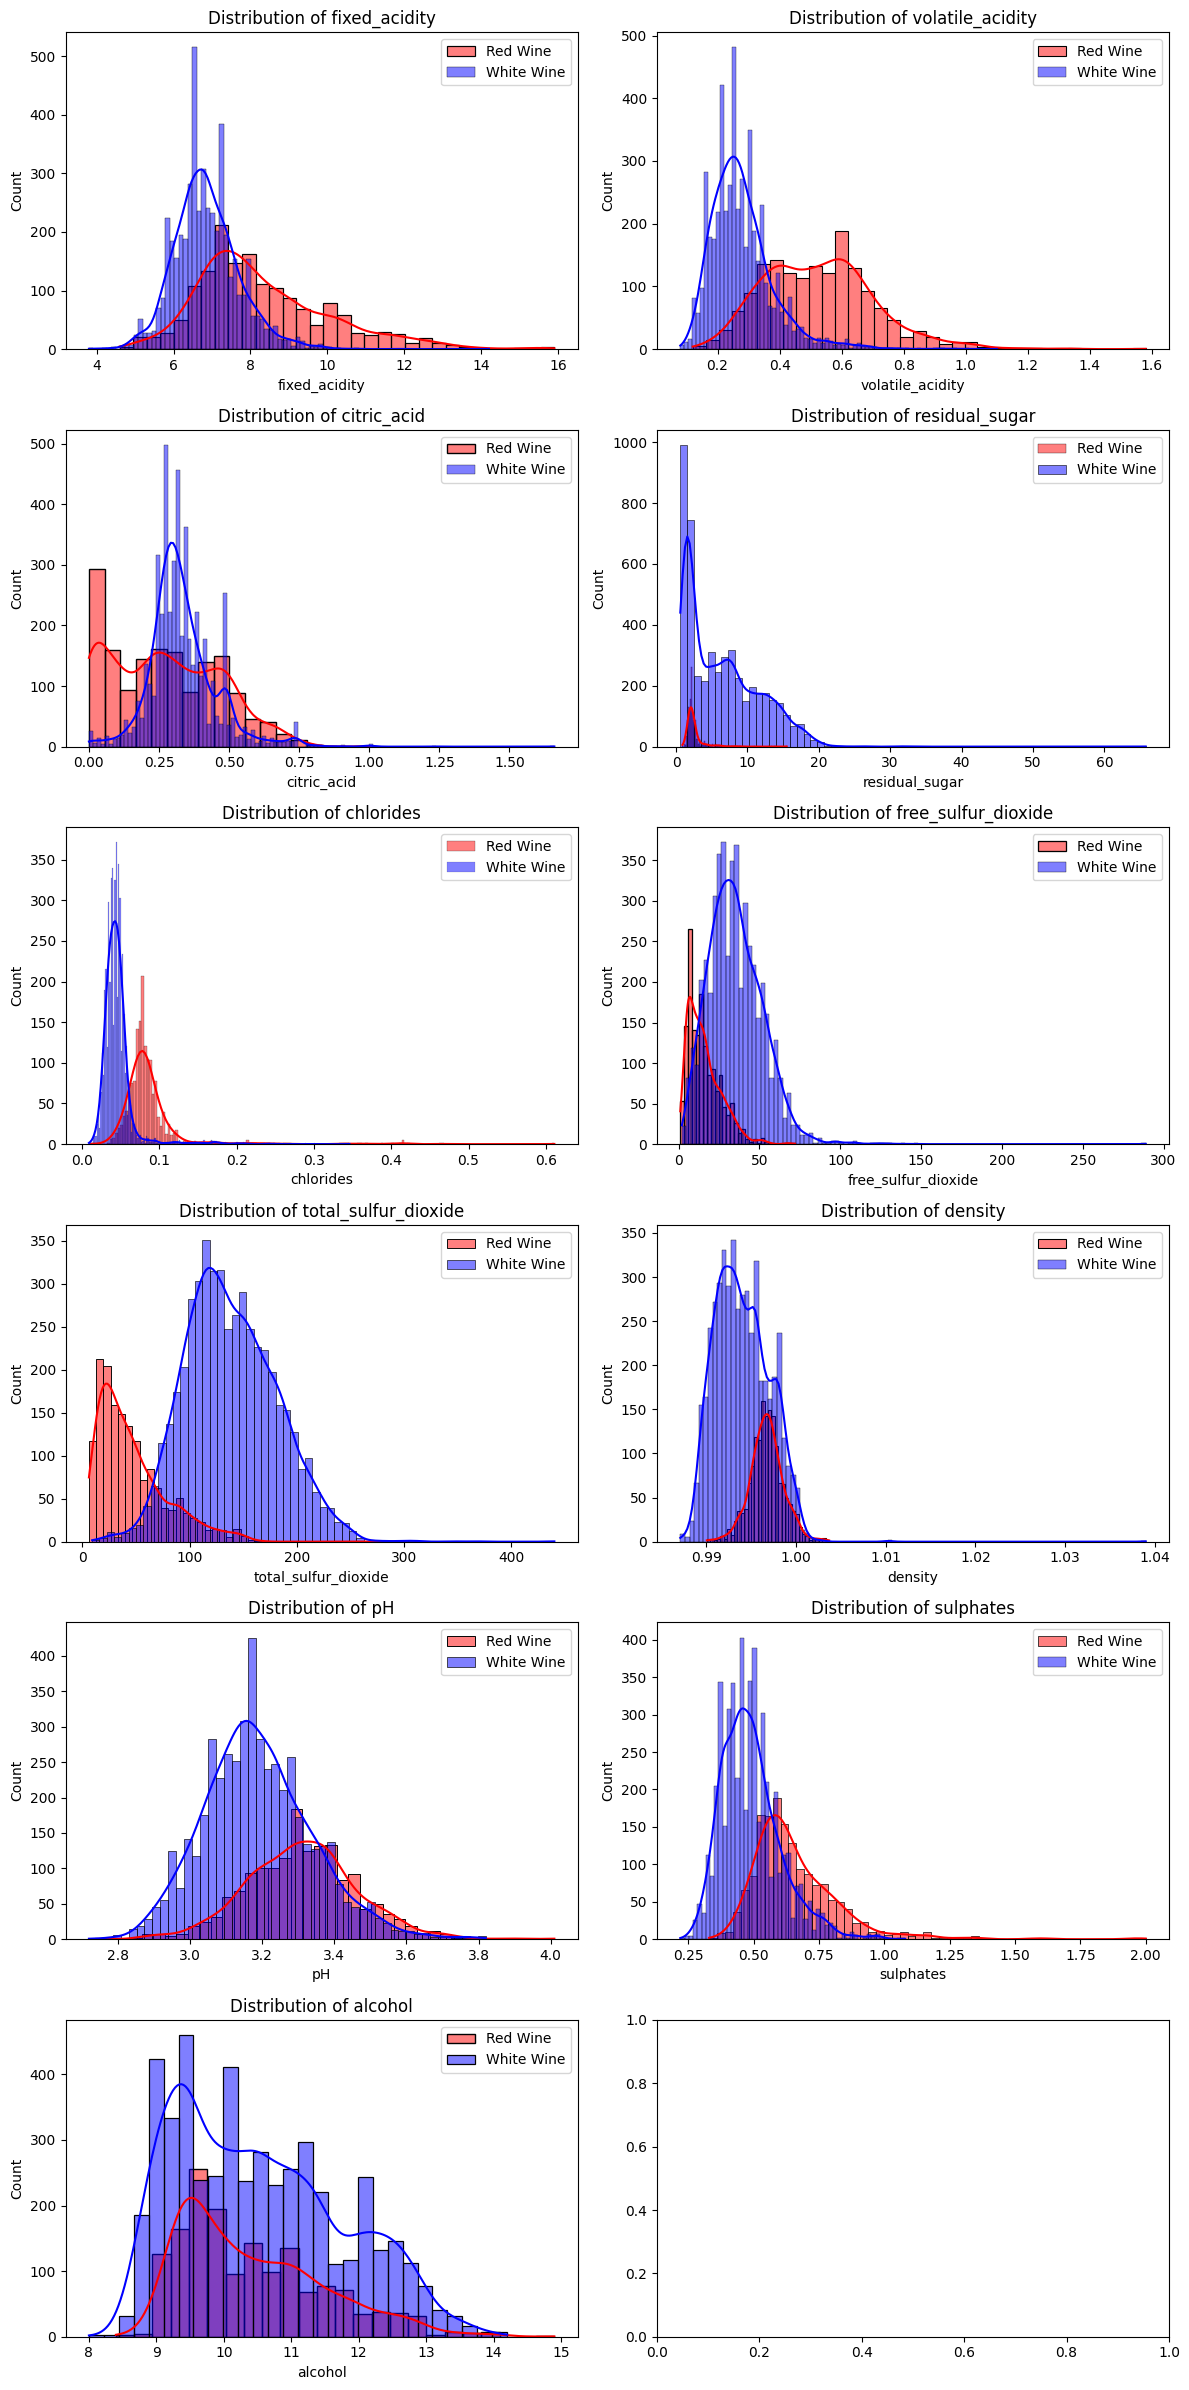

In [248]:
# Set the number of rows and columns for the subplots grid
n_rows = len(features) // 2 + len(features) % 2  # Two features per row

# Set up the matplotlib figure
fig, axes = plt.subplots(n_rows, 2, figsize=(12, n_rows * 4))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot histograms for each feature
for i, feature in enumerate(features):
    sns.histplot(
        red_wine_df[feature], color="red", label="Red Wine", ax=axes[i], kde=True
    )
    sns.histplot(
        white_wine_df[feature], color="blue", label="White Wine", ax=axes[i], kde=True
    )

    # Set the title and labels
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")
    axes[i].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

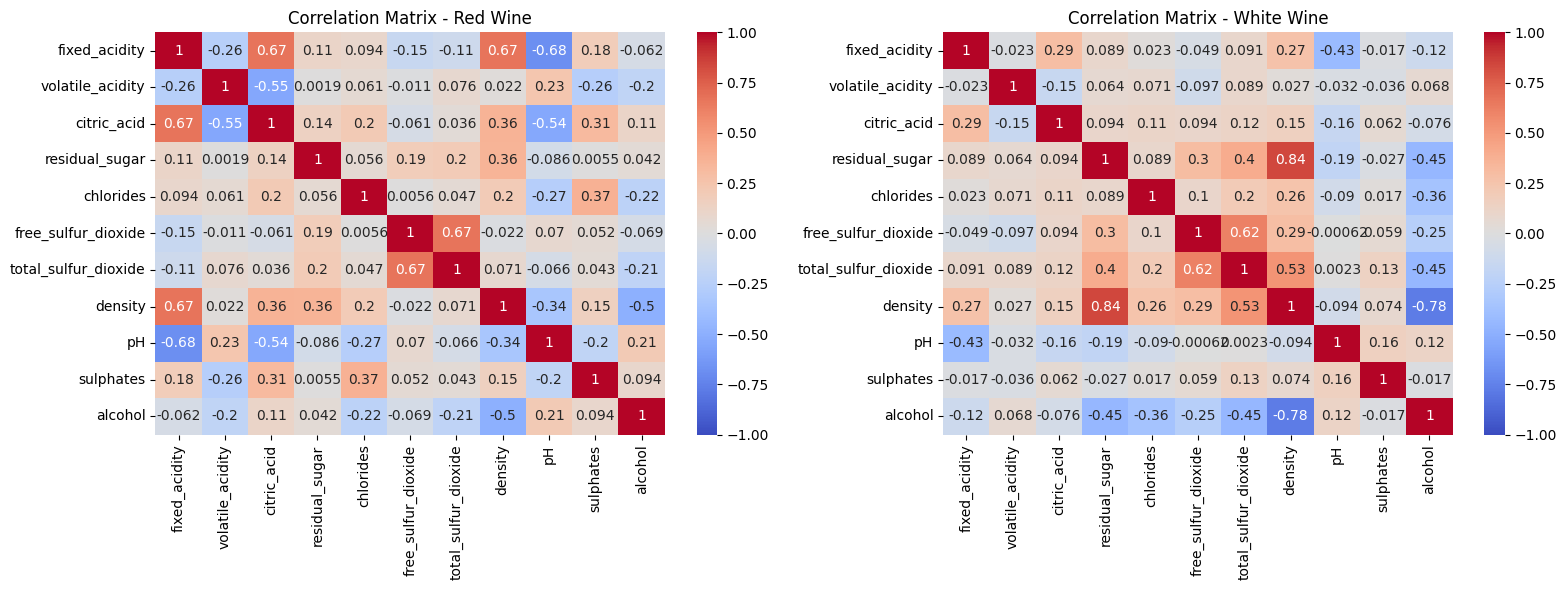

In [249]:
# Compute the correlation matrices
red_corr = red_wine_df[features].corr()  # Correlation matrix for red wines
white_corr = white_wine_df[features].corr()  # Correlation matrix for white wines

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the heatmap for red wines
sns.heatmap(red_corr, annot=True, cmap="coolwarm", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Correlation Matrix - Red Wine")

# Plot the heatmap for white wines
sns.heatmap(white_corr, annot=True, cmap="coolwarm", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Correlation Matrix - White Wine")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Analysis: Red Wine

High correlation: 
- CitricAcid/FixedAcidity 
- Density/FixedAcidity 
- totalSulfurDioxyde/freesulfurdioxide

Histogramme 
cons: certain bin ont 0 donnné alors c'est chaint pour diviser

## Data Exploration using Unsupervised Learning (3h)

We first explore the data in an unsupervised fashion. Start by creating a heatmap of the average feature value for red and white wines. Can you spot an easy way to differentiate between reds and whites?

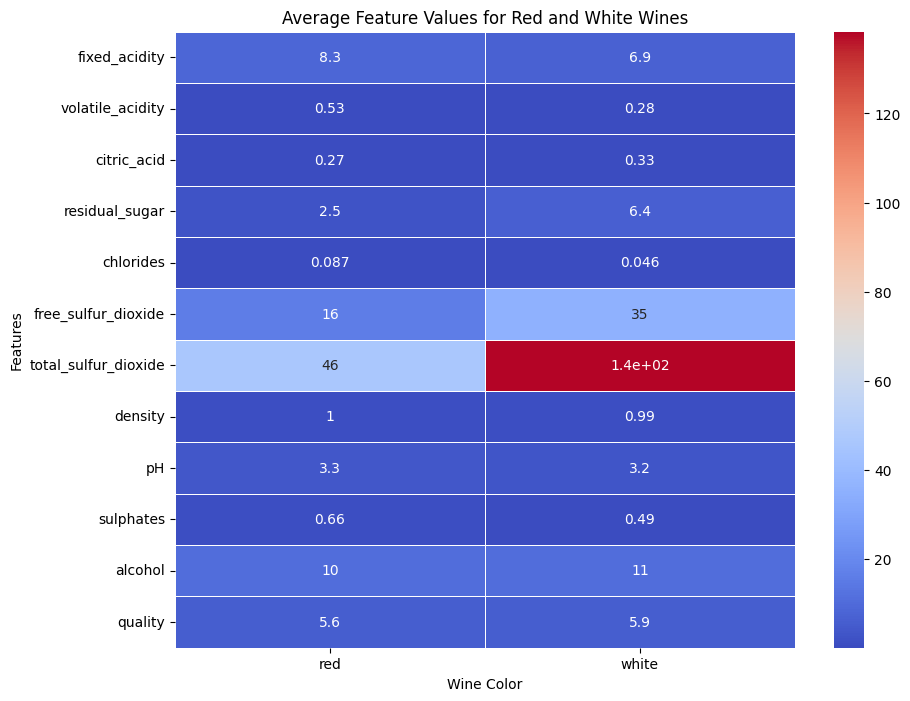

In [250]:
# Group data by wine color and calculate the mean of each feature

average_features = wine_df.groupby("color").mean()

# Transpose the data for better visualization in the heatmap
average_features_transposed = average_features.T

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap of the average feature values for red and white wines
sns.heatmap(average_features_transposed, annot=True, cmap="coolwarm", linewidths=0.5)

# Set the title and labels
plt.title("Average Feature Values for Red and White Wines")
plt.xlabel("Wine Color")
plt.ylabel("Features")

# Show the plot
plt.show()

### Using PCA to reduce the dimensionality

Use PCA to reduce the dimensionality of data. Do not forget that it requires data normalization (centering on the mean and scaling to unit variance). Plot the whole dataset onto the two principal components and color it by wine color. What does it tell you?

Project the unit vectors that correspond to each vector onto the principal components, using the same transformation. What does it tell you about the relative feature importance? Does it match the observations you made previously?

In [251]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [252]:
wine_df_encoded = wine_df_encoded.drop("quality", axis=1)
wine_df_encoded

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,0.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1.0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,1.0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1.0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1.0


In [253]:
y

0       5
1       5
2       5
3       6
4       5
       ..
6492    6
6493    5
6494    6
6495    7
6496    6
Name: quality, Length: 6497, dtype: int64

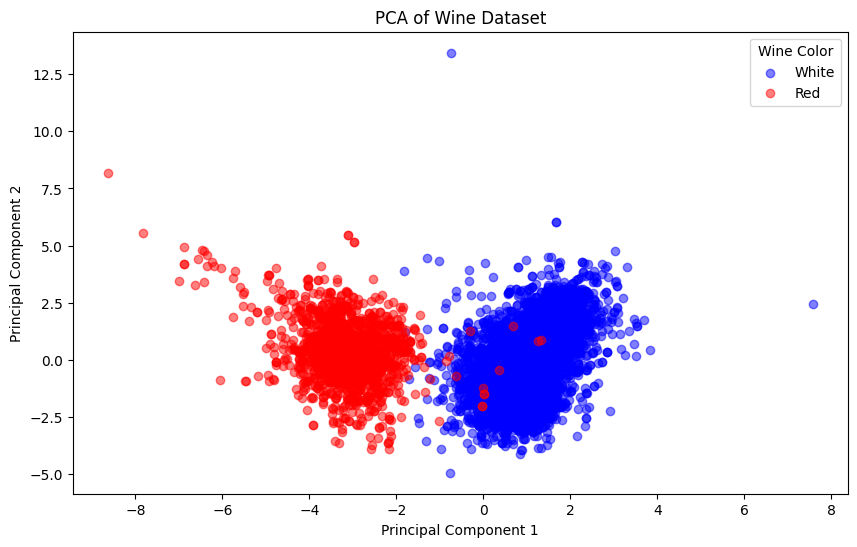

In [254]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Scale the features before applying PCA
sc = StandardScaler()
wine_df_scaled = sc.fit_transform(wine_df_encoded)

# Perform PCA to reduce to 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(wine_df_scaled)

# Create a DataFrame with the two principal components
pca_df_2 = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])

# Add the wine color column (color_white) to the PCA DataFrame
pca_df_2["color_white"] = wine_df_encoded[
    "color_white"
]  # assuming 1 = white wine, 0 = red wine

# Plot the two principal components, coloring by wine color
plt.figure(figsize=(10, 6))
colors = {1: "blue", 0: "red"}  # blue for white wine, red for red wine
for wine_color in colors:
    plt.scatter(
        pca_df_2.loc[pca_df_2["color_white"] == wine_color, "PC1"],
        pca_df_2.loc[pca_df_2["color_white"] == wine_color, "PC2"],
        c=colors[wine_color],
        label="White" if wine_color == 1 else "Red",
        alpha=0.5,
    )

plt.title("PCA of Wine Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Wine Color")
plt.show()

In [255]:
# Step 3: Get the PCA loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame to analyze the loadings
loadings_df = pd.DataFrame(
    loadings,
    index=wine_df_encoded.columns,
    columns=[f"PC{i+1}" for i in range(loadings.shape[1])],
)

# Step 4: Project the unit vectors onto the principal components
projections = loadings_df.T  # Transpose to align correctly

# Display the loadings and projections DataFrame
loadings_df, projections

(                           PC1       PC2
 fixed_acidity        -0.501677  0.433701
 volatile_acidity     -0.700480  0.054203
 citric_acid           0.222913  0.329793
 residual_sugar        0.480020  0.632609
 chlorides            -0.576437  0.383557
 free_sulfur_dioxide   0.674147  0.269432
 total_sulfur_dioxide  0.806152  0.304146
 density              -0.277212  0.892598
 pH                   -0.352656 -0.308906
 sulphates            -0.551649  0.192384
 alcohol              -0.038588 -0.756913
 color_white           0.918624 -0.121857,
      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
 PC1      -0.501677         -0.700480     0.222913        0.480020  -0.576437   
 PC2       0.433701          0.054203     0.329793        0.632609   0.383557   
 
      free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
 PC1             0.674147              0.806152 -0.277212 -0.352656  -0.551649   
 PC2             0.269432              0.304

### Interpretation of Loadings and Projections

**Loadings**: 
Each entry in the `loadings_df` indicates how much each original feature contributes to each principal component. For instance, if **alcohol** has a high loading for **PC1**, it suggests that alcohol is a significant factor in explaining the variance captured by the first principal component.

**Projections**: 
The projections of the unit vectors (from the loadings) onto the two principal components can help assess the relationship between the original features and the principal components. This provides insight into how the original features relate to the reduced dimensions.

### Observations

**Relative Feature Importance**:
Features with larger absolute loadings indicate stronger contributions to the respective principal components. For example, if **alcohol** and **sulphates** have high loadings on **PC1**, they are essential for differentiating the wines along that component.

**Matching Previous Observations**:
Compare these loadings with your previous observations from the PCA plot. If your earlier visualizations showed that the wine types were separated along a certain axis, check if the corresponding feature loadings are high for that principal component.


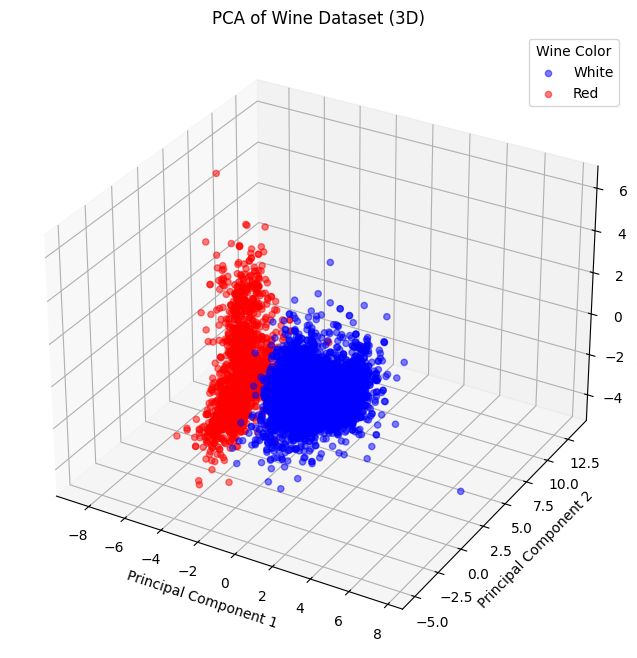

In [256]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'wine_df_encoded' is your DataFrame
# Scale the features before applying PCA
sc = StandardScaler()
wine_df_scaled = sc.fit_transform(wine_df_encoded)

# Perform PCA to reduce to 3 components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(wine_df_scaled)

# Create a DataFrame with the three principal components
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2", "PC3"])

# Add the wine color column (color_white) to the PCA DataFrame
pca_df["color_white"] = wine_df_encoded[
    "color_white"
]  # assuming 1 = white wine, 0 = red wine

# Plot the three principal components in a 3D plot, coloring by wine color
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot each wine type with a different color
colors = {1: "blue", 0: "red"}  # blue for white wine, red for red wine
for wine_color in colors:
    ax.scatter(
        pca_df.loc[pca_df["color_white"] == wine_color, "PC1"],
        pca_df.loc[pca_df["color_white"] == wine_color, "PC2"],
        pca_df.loc[pca_df["color_white"] == wine_color, "PC3"],
        c=colors[wine_color],
        label="White" if wine_color == 1 else "Red",
        alpha=0.5,
    )

# Set axis labels and title
ax.set_title("PCA of Wine Dataset (3D)")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.legend(title="Wine Color")
plt.show()

# Understanding Principal Components in PCA

## What Are Principal Components?

Principal Components (PCs) are new variables created through Principal Component Analysis (PCA) that summarize the information contained in the original dataset. Each principal component is a linear combination of the original features, and they are ordered by the amount of variance they explain in the data.

## Interpretation of Principal Components

1. **Principal Component 1 (PC1)**:
   - **Variance Explained**: PC1 captures the maximum variance present in the dataset. It represents the direction in which the data varies the most.
   - **Features Contribution**: The weights assigned to each feature in the linear combination of PC1 indicate how much each feature contributes to this principal component. A high weight implies that the feature significantly influences this component.

2. **Principal Component 2 (PC2)**:
   - **Variance Explained**: PC2 captures the second highest variance, orthogonal (uncorrelated) to PC1. This means it provides a different perspective on the data variation not captured by PC1.
   - **Features Contribution**: Similar to PC1, the weights of the original features in PC2 help identify which features contribute to the variation along this axis.

3. **Principal Component 3 (PC3)**:
   - **Variance Explained**: PC3 captures the third highest variance in the data, again orthogonal to both PC1 and PC2. It helps to explore further dimensions of the dataset.
   - **Features Contribution**: The contribution of features to PC3 provides insight into additional patterns in the data that were not explained by the first two components.

## Understanding the Results

- **Visualization**: By plotting the dataset against these principal components, you can visualize how well different groups (like red and white wines) are separated. 
- **Correlation with Features**: Analyzing the loadings (weights) of each feature on the principal components can provide insights into which features are most important for distinguishing between classes (e.g., wine types).
- **Dimensionality Reduction**: Using the first few principal components allows for effective dimensionality reduction while retaining most of the information in the dataset, facilitating easier analysis and visualization.

## Conclusion

Principal components provide a powerful way to reduce the complexity of your dataset while retaining the most important information. By understanding the meaning and contribution of each principal component, you can gain deeper insights into the characteristics that differentiate between different types of wines in your dataset.
Principal components are not the same as the original features. Instead, they are a weighted sum of the original features. For example, PC1 might be a combination of fixed_acidity, alcohol, pH, and other features, but with different weights.

In [257]:
wine_df_encoded

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,0.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1.0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,1.0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1.0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1.0


In [258]:
sc = StandardScaler()
wine_df_scaled = pd.DataFrame(
    sc.fit_transform(wine_df_encoded), columns=wine_df_encoded.columns
)
wine_df_scaled

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color_white
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,-1.750190
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068,-1.750190
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068,-1.750190
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068,-1.750190
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,-1.750190
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.783214,-0.787650,-0.197054,-0.807837,-0.486252,-0.367664,-0.420128,-1.186161,0.320319,-0.210144,0.593818,0.571367
6493,-0.474652,-0.119460,0.284686,0.537425,-0.257883,1.491697,0.924588,0.067824,-0.426067,-0.478971,-0.747766,0.571367
6494,-0.551792,-0.605417,-0.885253,-0.891916,-0.429160,-0.029599,-0.083949,-0.719251,-1.421248,-0.478971,-0.915464,0.571367
6495,-1.323198,-0.301694,-0.128234,-0.912936,-0.971538,-0.593041,-0.101642,-2.003251,0.755710,-1.016626,1.935402,0.571367


### Cluster the data in 2-dimensional space

Use k-means to cluster the data into 2 clusters and plot the same view as before, but with a coloring that corresponds to the cluster memberships.

Assuming that the cluster assignments are predictions of a model, what is the performance you can achieve in terms of mutual information score, accuracy, and f1 score?

In [259]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score, accuracy_score, f1_score

In [260]:
kmeans = KMeans(n_clusters=2, random_state=42)
# create new column
pca_df_2["cluster"] = kmeans.fit_predict(principal_components)

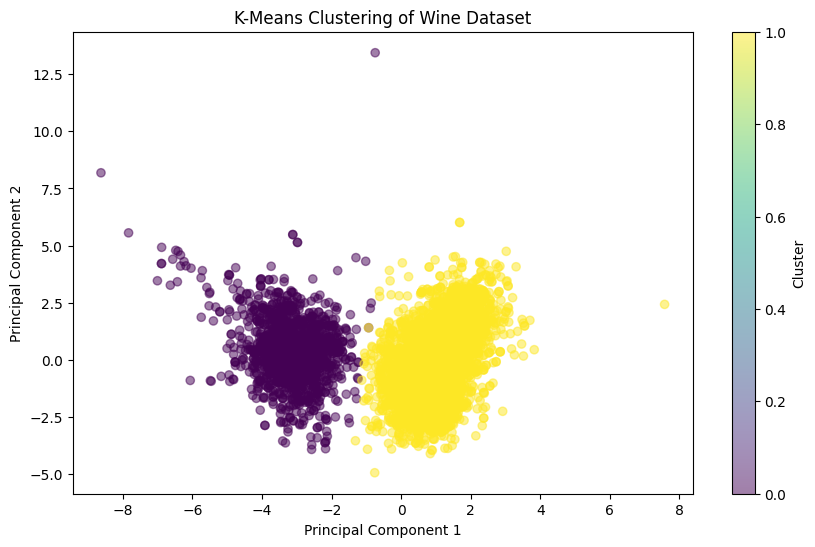

In [261]:
# Step 2: Plot the clusters in 2D space
plt.figure(figsize=(10, 6))
plt.scatter(
    pca_df_2["PC1"], pca_df_2["PC2"], c=pca_df_2["cluster"], cmap="viridis", alpha=0.5
)
plt.title("K-Means Clustering of Wine Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

In [262]:
# Step 3: Evaluate the clustering performance
# True labels
true_labels = pca_df_2["color_white"]

# Predicting cluster memberships
predicted_clusters = pca_df_2["cluster"]

# Calculate Mutual Information Score
mutual_info = mutual_info_score(true_labels, predicted_clusters)

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predicted_clusters)

# Calculate F1 Score
f1 = f1_score(true_labels, predicted_clusters)

# Display the metrics
print(f"Mutual Information Score: {mutual_info}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Mutual Information Score: 0.5287554493943263
Accuracy: 0.9952285670309373
F1 Score: 0.9968344736035945


Mutual Information Score: 
- This metric measures the amount of information that knowing the cluster assignment provides about the true labels. 
- A higher score indicates better clustering performance.

Now, we are going to train a **supervised** linear classification model using `sklearn`, and compare the results with the approach using clustering.

- Set up a train/test dataset using `sklearn.model_selection.train_test_split`.
- Use `GridSearchCV` to perform a cross-validation of the model's regularization `C`.
- Compare the test and train performance at the end. Does the model suffer from any overfitting? 
- Analyze the test performance specifically. What can you conclude about this general problem of recognizing white vs red wines?

In [263]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [264]:
X = wine_df_scaled

In [265]:
y

0       5
1       5
2       5
3       6
4       5
       ..
6492    6
6493    5
6494    6
6495    7
6496    6
Name: quality, Length: 6497, dtype: int64

In [266]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [267]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Set up the parameter grid for C (regularization parameter)
param_grid = {"C": [0.01, 0.1, 1, 10, 100]}

# Set up the logistic regression model
model = LogisticRegression(max_iter=1000)

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_model = grid_search.best_estimator_
print("Best C parameter:", grid_search.best_params_)

c:\Users\capma\Documents\GitHub\w4-isc-ml-caporizzi\.venv\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best C parameter: {'C': 10}


In [268]:
from sklearn.metrics import accuracy_score

# Training set performance
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy: {:.2f}%".format(train_accuracy * 100))

# Test set performance
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Train Accuracy: 54.86%
Test Accuracy: 54.31%


Analysis:

Overfitting: 
- If the training accuracy is much higher than the test accuracy, this suggests that the model is overfitting, meaning it performs well on the training data but poorly on unseen test data. 
- If the two accuracies are close, the model generalizes well.

Test Performance: 
- Look at the test accuracy to determine how well the model is able to distinguish between white and red wines based on the features. 
- If the accuracy is high, the model performs well at this task. 
- If not, further tuning of hyperparameters or trying other models may help

### Basic model interpretability: inspecting the model

As a first step towards intepretability of the model predictions, let's take a look at the coefficients of the model. What is the most important feature from this perspective? How do you interpret positive or negative coefficients?

Is it compatible with what you have seen so far? Do you have an explanation why that might be?

In [269]:
# Complete this cell with your code
# Get the feature names from the dataframe
feature_names = X_train.columns

# Extract the coefficients from the trained model
coefficients = best_model.coef_[0]

# Create a dataframe to organize the feature names and their coefficients
coefficients_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

# Sort by the absolute value of the coefficients (magnitude of impact)
coefficients_df["Absolute Coefficient"] = np.abs(coefficients_df["Coefficient"])
coefficients_df = coefficients_df.sort_values(
    by="Absolute Coefficient", ascending=False
)

# Display the sorted coefficients
print(coefficients_df)

                 Feature  Coefficient  Absolute Coefficient
1       volatile_acidity     1.033745              1.033745
11           color_white     1.030912              1.030912
4              chlorides     1.012397              1.012397
10               alcohol    -0.779217              0.779217
0          fixed_acidity     0.656487              0.656487
5    free_sulfur_dioxide     0.638238              0.638238
6   total_sulfur_dioxide    -0.469964              0.469964
9              sulphates    -0.460401              0.460401
8                     pH     0.396053              0.396053
3         residual_sugar    -0.196600              0.196600
7                density    -0.195343              0.195343
2            citric_acid    -0.069818              0.069818


Volatile Acidity (+1.033745):

- This feature has the highest positive coefficient, indicating that higher levels of volatile acidity increase the likelihood of the wine being classified as red. 
- This makes sense because red wines generally have higher levels of volatile acidity compared to white wines.

Chlorides (+1.012397):

- Chlorides also show a strong positive effect, suggesting that higher chloride content is associated with red wines. 
- This could be because red wines often have slightly higher chloride content compared to white wines.

- Positive Coefficients: Features like volatile acidity, chlorides, and color_white (when not white) push the prediction towards red wines.
- Negative Coefficients: Features like alcohol, total sulfur dioxide, and sulphates push the prediction towards white wines.

### Removing features to test their importance

- What happens if you re-train a model, but remove the most important feature in the list?
- What happens if you re-train the model with a `l1` penalty and you use more regularization? 
- Interpret the results you obtained above from the perspective of the business problem. What does it tell you about the key differences between a red and white wine?

In [270]:
# Complete this cell with your code
# Drop the most important feature: volatile_acidity
X_reduced = X.drop("volatile_acidity", axis=1)

# Train/test split
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)

# Re-train the model
model_reduced = LogisticRegression(max_iter=1000)
model_reduced.fit(X_train_reduced, y_train)

# Evaluate the new model
y_train_pred_reduced = model_reduced.predict(X_train_reduced)
y_test_pred_reduced = model_reduced.predict(X_test_reduced)

train_accuracy_reduced = accuracy_score(y_train, y_train_pred_reduced)
test_accuracy_reduced = accuracy_score(y_test, y_test_pred_reduced)

print(f"Train Accuracy after removing volatile_acidity: {train_accuracy_reduced:.2f}")
print(f"Test Accuracy after removing volatile_acidity: {test_accuracy_reduced:.2f}")

Train Accuracy after removing volatile_acidity: 0.54
Test Accuracy after removing volatile_acidity: 0.54


No performance change !

In [271]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Set up logistic regression with l1 penalty
model_l1 = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000)

# Set up the parameter grid for stronger regularization (smaller C means stronger regularization)
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10]}

# Grid search with 5-fold cross-validation
grid_search_l1 = GridSearchCV(model_l1, param_grid, cv=5)
grid_search_l1.fit(X_train, y_train)

# Best parameters and coefficients from the l1 model
best_model_l1 = grid_search_l1.best_estimator_
print("Best C parameter for l1 model:", grid_search_l1.best_params_)

# Evaluate the model
y_test_pred_l1 = best_model_l1.predict(X_test)
test_accuracy_l1 = accuracy_score(y_test, y_test_pred_l1)
print(f"Test Accuracy with l1 regularization: {test_accuracy_l1:.2f}")

# Check which features have non-zero coefficients
print("Non-zero coefficients:", np.sum(best_model_l1.coef_ != 0))

c:\Users\capma\Documents\GitHub\w4-isc-ml-caporizzi\.venv\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best C parameter for l1 model: {'C': 10}
Test Accuracy with l1 regularization: 0.53
Non-zero coefficients: 83


Sparsity: 

- The l1 penalty should result in fewer active (non-zero) coefficients, as it forces some features to be ignored entirely. - This means the model will focus on the most important features, potentially leading to a more interpretable model.

Regularization Impact: 

- Increasing regularization (lower C) will make the model simpler and may lead to better generalization, but if too strong, it could harm the accuracy.

# Good vs Bad classification (3h)

We are going to work on a binary classification problem, where all wines with a quality higher than 6 are considered as "good" and other are considered as "bad".  

- Prepare a dataset with a new column `binary_quality` that corresponds to the above definition.

In [272]:
X

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color_white
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,-1.750190
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068,-1.750190
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068,-1.750190
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068,-1.750190
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,-1.750190
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.783214,-0.787650,-0.197054,-0.807837,-0.486252,-0.367664,-0.420128,-1.186161,0.320319,-0.210144,0.593818,0.571367
6493,-0.474652,-0.119460,0.284686,0.537425,-0.257883,1.491697,0.924588,0.067824,-0.426067,-0.478971,-0.747766,0.571367
6494,-0.551792,-0.605417,-0.885253,-0.891916,-0.429160,-0.029599,-0.083949,-0.719251,-1.421248,-0.478971,-0.915464,0.571367
6495,-1.323198,-0.301694,-0.128234,-0.912936,-0.971538,-0.593041,-0.101642,-2.003251,0.755710,-1.016626,1.935402,0.571367


In [273]:
# Convert y directly into a binary classification (1 for good, 0 for bad)
y_binary = y.apply(lambda x: 1 if x > 6 else 0)

# Display the first few entries of y_binary to check the result
print(y_binary.value_counts())

quality
0    5220
1    1277
Name: count, dtype: int64


One question that we might ask right away is:

- Is there any correlation of the quality and the color of the wine? 

Ideally, there should be almost none. Why could it be a problem otherwise?

In [274]:
# Converting 'color' to binary: 1 for white, 0 for red
wine_df["color_binary"] = wine_df["color"].apply(lambda x: 1 if x == "white" else 0)

# Converting 'quality' to binary: 1 for good (quality > 6), 0 for bad (quality <= 6)
wine_df["binary_quality"] = wine_df["quality"].apply(lambda x: 1 if x > 6 else 0)

# Display the updated dataframe

wine_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color,color_binary,binary_quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red,0,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red,0,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red,0,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red,0,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white,1,0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white,1,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white,1,0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white,1,1


In [275]:
# Complete this cell with your code
# Assuming 'color_white' is a binary column (1 for white, 0 for red)
correlation = wine_df["binary_quality"].corr(wine_df["color_binary"])

print(f"Correlation between quality and color: {correlation}")

Correlation between quality and color: 0.08747895850677735


If it turns out that there are significantly more bad red wines than bad white wines or vice versa, what are the implications for your analysis?

- Plot a heatmap of the mean feature value for bad and good wines, like we did before for red and white wines.
- Plot two heatmaps, one for red and white wines. How do they differ? What kind of issue can it cause?

In [276]:
wine_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color,color_binary,binary_quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red,0,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red,0,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red,0,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red,0,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white,1,0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white,1,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white,1,0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white,1,1


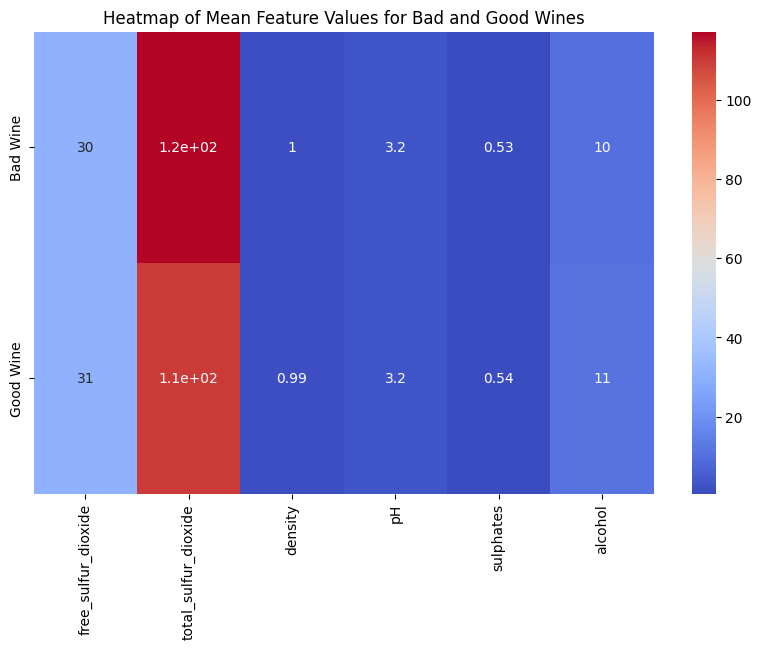

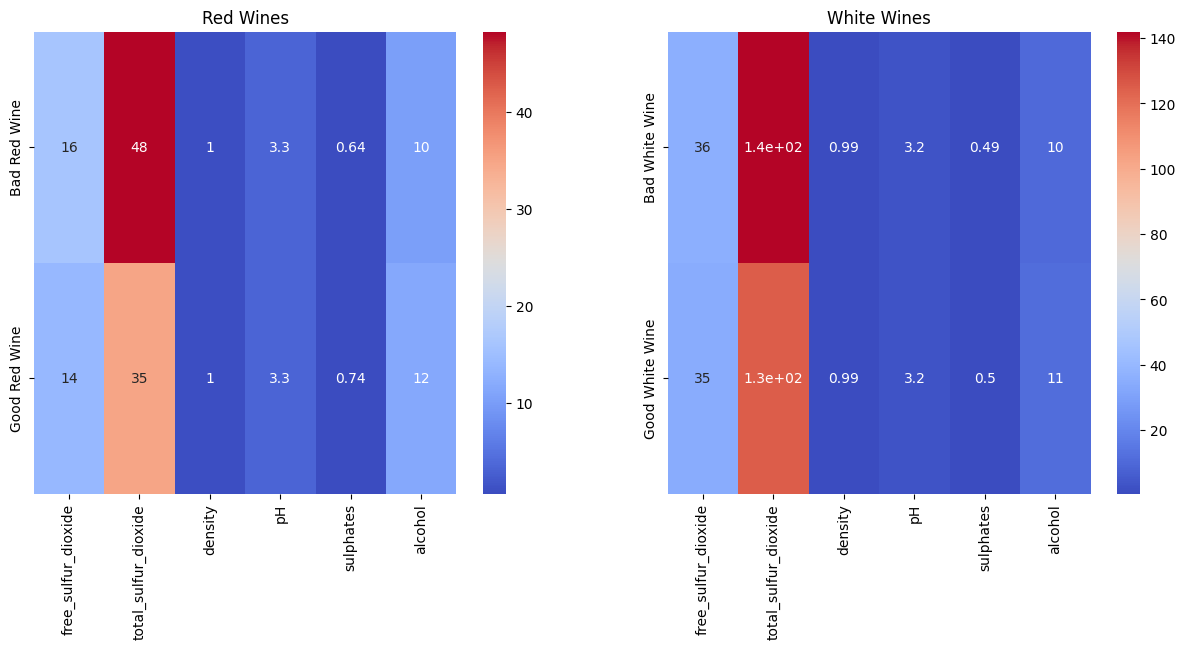

In [277]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming wine_df is already loaded into your environment
# Compute mean feature values for bad and good wines
bad_wines = wine_df[wine_df["binary_quality"] == 0]
good_wines = wine_df[wine_df["binary_quality"] == 1]

# Select only the feature columns for the heatmap (excluding categorical columns)
feature_columns = [
    "free_sulfur_dioxide",
    "total_sulfur_dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]

# Calculate the mean values for bad and good wines
mean_bad_wines = bad_wines[feature_columns].mean()
mean_good_wines = good_wines[feature_columns].mean()

# Create a DataFrame for mean values
mean_df = pd.DataFrame({"Bad Wine": mean_bad_wines, "Good Wine": mean_good_wines})

# Plot heatmap for bad and good wines
plt.figure(figsize=(10, 6))
sns.heatmap(mean_df.T, cmap="coolwarm", annot=True)
plt.title("Heatmap of Mean Feature Values for Bad and Good Wines")
plt.show()

# Now create separate heatmaps for red and white wines
red_wines = wine_df[wine_df["color_binary"] == 0]
white_wines = wine_df[wine_df["color_binary"] == 1]

# Compute mean feature values for bad and good red wines
mean_bad_red_wines = red_wines[red_wines["binary_quality"] == 0][feature_columns].mean()
mean_good_red_wines = red_wines[red_wines["binary_quality"] == 1][
    feature_columns
].mean()

# Compute mean feature values for bad and good white wines
mean_bad_white_wines = white_wines[white_wines["binary_quality"] == 0][
    feature_columns
].mean()
mean_good_white_wines = white_wines[white_wines["binary_quality"] == 1][
    feature_columns
].mean()

# Plot heatmaps for red and white wines separately
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Heatmap for red wines
mean_df_red = pd.DataFrame(
    {"Bad Red Wine": mean_bad_red_wines, "Good Red Wine": mean_good_red_wines}
)
sns.heatmap(mean_df_red.T, cmap="coolwarm", annot=True, ax=ax[0])
ax[0].set_title("Red Wines")

# Heatmap for white wines
mean_df_white = pd.DataFrame(
    {"Bad White Wine": mean_bad_white_wines, "Good White Wine": mean_good_white_wines}
)
sns.heatmap(mean_df_white.T, cmap="coolwarm", annot=True, ax=ax[1])
ax[1].set_title("White Wines")

plt.show()

Differences between Bad and Good Wines:

- There are notable differences in sulfur dioxide levels between bad and good wines (both red and white). 
- Bad wines tend to have higher levels of both free and total sulfur dioxide.
- Alcohol levels are generally higher in good wines, which suggests that higher alcohol content may contribute positively to wine quality.
- pH and density values do not appear to vary significantly between bad and good wines, which may indicate that these factors are less influential on perceived quality.

Red vs. White Wines:

- The mean sulfur dioxide levels are generally much higher for white wines than red wines. 
- This could imply a different winemaking process where sulfur dioxide plays a stronger role in preserving or treating white wines.
- Red wines show higher average levels of sulphates, which may influence their overall taste and preservation.
- Alcohol content is slightly higher in good red wines compared to white wines.

Potential Issues with the Analysis:

Class Imbalance: 
- If there is a significant difference in the number of good and bad wines between red and white wine categories, it can introduce bias. For example, if there are far more bad red wines than bad white wines, the overall mean feature values for bad wines could be skewed by this imbalance. This would affect how we interpret the importance of different features.

Different Characteristics: 
- Red and white wines may have inherently different chemical properties due to grape varieties and winemaking processes. - - Thus, lumping them together in a single binary comparison (color or quality) without accounting for these inherent differences might mask important insights. 
- It might be better to evaluate the wine types separately for more accurate results.

It is a lot more difficult now to tell apart good from bad wines. Let's turn to a more complex model, which is a [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) [Trees](https://xgboost.readthedocs.io/en/stable/tutorials/model.html). For the sake of interpretability, design your notebook so that you can easily filter on only white and red wines and perform again the entire procedure.

Let's first train a XGBClassifier model to distinguish between good and bad wines. Make sure to use the same best-practices (train/test split, cross-validation) as we did before. Note that the regularization of the GBTs is a lot more complex than for Logistic Regression. Test the following parameters:

  ```py
  param_grid = {
    "max_depth": [3, 4, 5],  # Focus on shallow trees to reduce complexity
    "learning_rate": [0.01, 0.05, 0.1],  # Slower learning rates
    "n_estimators": [50, 100],  # More trees but keep it reasonable
    "min_child_weight": [1, 3],  # Regularization to control split thresholds
    "subsample": [0.7, 0.9],  # Sampling rate for boosting
    "colsample_bytree": [0.7, 1.0],  # Sampling rate for columns
    "gamma": [0, 0.1],  # Regularization to penalize complex trees
  }
  ```

In [278]:
# Complete this cell with your code
# Filter on only white or red wines
red_wines = wine_df[wine_df["color"] == "red"]
white_wines = wine_df[wine_df["color"] == "white"]

# Let's proceed with red wines for now (you can do the same for white wines)
X = red_wines.drop(columns=["binary_quality", "quality", "color", "color_binary"])
y = red_wines["binary_quality"]
X

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


In [279]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [280]:
# XGBClassifier with GridSearchCV
param_grid = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100],
    "min_child_weight": [1, 3],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 1.0],
    "gamma": [0, 0.1],
}

In [281]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [282]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb, param_grid=param_grid, scoring="accuracy", cv=5, verbose=1, n_jobs=-1
)
fitted_xsb = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


c:\Users\capma\Documents\GitHub\w4-isc-ml-caporizzi\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:01:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [283]:
# Best parameters from the grid search
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}


- Analyze the results (test and train), validate whether there is overfitting.

In [284]:
# Complete this cell with your code
# Evaluate on training set
y_train_pred = grid_search.best_estimator_.predict(X_train)
print("Training Set Performance:")
print(classification_report(y_train, y_train_pred))

# Evaluate on test set
y_test_pred = grid_search.best_estimator_.predict(X_test)
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

Training Set Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1109
           1       1.00      0.92      0.96       170

    accuracy                           0.99      1279
   macro avg       0.99      0.96      0.98      1279
weighted avg       0.99      0.99      0.99      1279

Test Set Performance:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       273
           1       0.74      0.49      0.59        47

    accuracy                           0.90       320
   macro avg       0.83      0.73      0.77       320
weighted avg       0.89      0.90      0.89       320



Training set:
- This indicates that the model is performing almost perfectly on the training data, suggesting it might be memorizing the training set rather than learning general patterns.

Test set:
- While the model performs well for class 0 (probably "bad wines") in the test set, its performance for class 1 (probably "good wines") is significantly worse, with a recall of only 49%, meaning it's missing a lot of the "good" wines. 
- The f1-score for class 1 is also low at 0.59, confirming that the model struggles with the minority class on unseen data.

## Interpretability with SHAP (2h)

- Plot the feature importance (gain and cover) from the XGBoost model. What can you conclude?

<Figure size 1000x800 with 0 Axes>

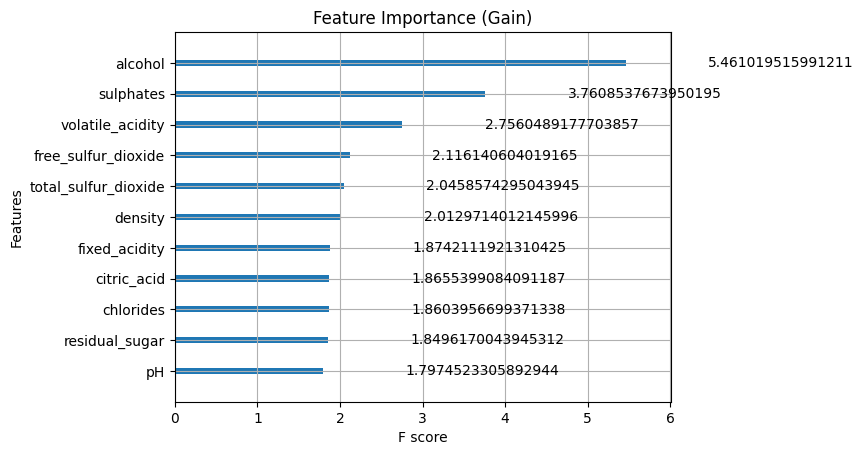

In [285]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
import shap

# Assuming you have the best model from grid search stored as 'fitted_xsb'
xgb_best = grid_search.best_estimator_

# Feature Importance by Gain
plt.figure(figsize=(10, 8))
plot_importance(xgb_best, importance_type="gain", title="Feature Importance (Gain)")
plt.show()

The **Feature Importance (Gain)** plot you provided ranks the features based on their contributions to improving the model’s accuracy (gain) when used in splits. Here's an interpretation of the results:

### Top Features by Gain:
1. **Alcohol** (5.46): 
   - This is the most important feature by a significant margin, meaning that splits using this feature result in the largest increase in model accuracy. The model heavily relies on the alcohol content when making decisions.
   
2. **Sulphates** (3.76): 
   - This feature is the second most impactful. Sulphates, which contribute to the wine's preservation and flavor, play a crucial role in predicting the target variable.

3. **Volatile Acidity** (2.76):
   - This is also an important feature, although less than alcohol and sulphates. It likely helps the model differentiate between classes based on acidity levels that affect the quality of the wine.

4. **Free Sulfur Dioxide** (2.12), **Total Sulfur Dioxide** (2.04), and **Density** (2.01):
   - These features have similar levels of importance. They are moderately important, contributing to splits that help the model improve accuracy. These variables likely relate to the preservation and texture of the wine.

### Features with Lower Gain:
- **pH** (1.79), **Residual Sugar** (1.85), **Chlorides** (1.86):
   - These features contribute to the model's accuracy but with smaller improvements. They are used in some decision splits but are not as crucial as the top-ranking features.

### Conclusion:
- **Alcohol** is by far the most important feature in improving the model's accuracy, followed by **sulphates** and **volatile acidity**. These top features are likely the primary factors influencing the model’s predictions.
- Features like **pH**, **residual sugar**, and **chlorides** are still useful but contribute less to model improvement.

<Figure size 1000x800 with 0 Axes>

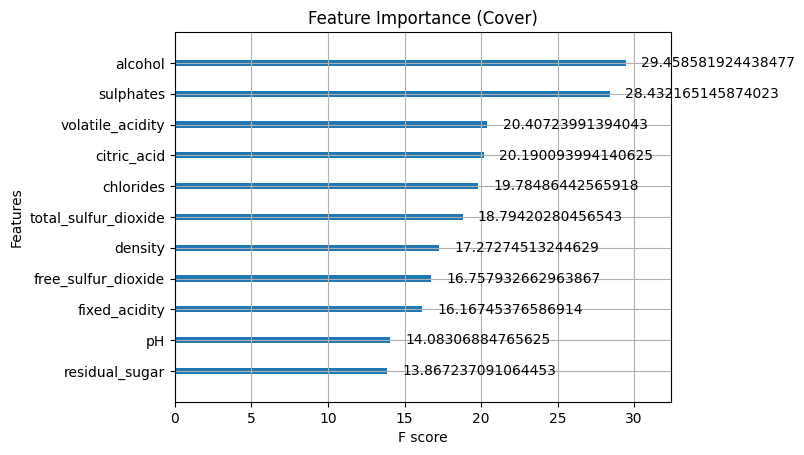

In [286]:
# Feature Importance by Cover
plt.figure(figsize=(10, 8))
plot_importance(xgb_best, importance_type="cover", title="Feature Importance (Cover)")
plt.show()



### Top Features by Cover:
1. **Alcohol** (29.46):
   - Alcohol content is the most frequently used feature in the decision-making process. This means that many decision trees in the model rely on alcohol content to split the data, impacting a significant portion of the dataset. While alcohol was also the top feature in terms of **gain**, here we see that it is also widely used across many decisions.
   
2. **Sulphates** (28.43):
   - Similar to alcohol, sulphates are very commonly used in the decision-making process. The model relies on this feature almost as much as alcohol, indicating that sulphates are relevant for many different predictions.

3. **Volatile Acidity** (20.41), **Citric Acid** (20.19), **Chlorides** (19.78):
   - These features are used frequently in the model, meaning they are involved in many splits across decision trees. While they may not have as high a **gain** as alcohol or sulphates, they are still important in terms of covering a large portion of the data.

### Features with Lower Cover:
- **Residual Sugar** (13.87), **pH** (14.08):
   - These features are used less often compared to the top features, meaning that the model doesn’t rely on them as much when splitting the data. However, they still play a role in certain decisions, albeit less frequently.

### Conclusion:
- **Alcohol** and **Sulphates** are not only the most impactful features (as seen in the **gain** plot) but are also widely used across the model’s decision trees. This suggests they are both powerful and versatile features.
- **Volatile Acidity**, **Citric Acid**, and **Chlorides** are used often but may not contribute as much to accuracy gains as alcohol or sulphates.
- The features with lower cover, such as **Residual Sugar** and **pH**, are less important in terms of how often they are used, indicating that the model does not rely on them as frequently for decisions.



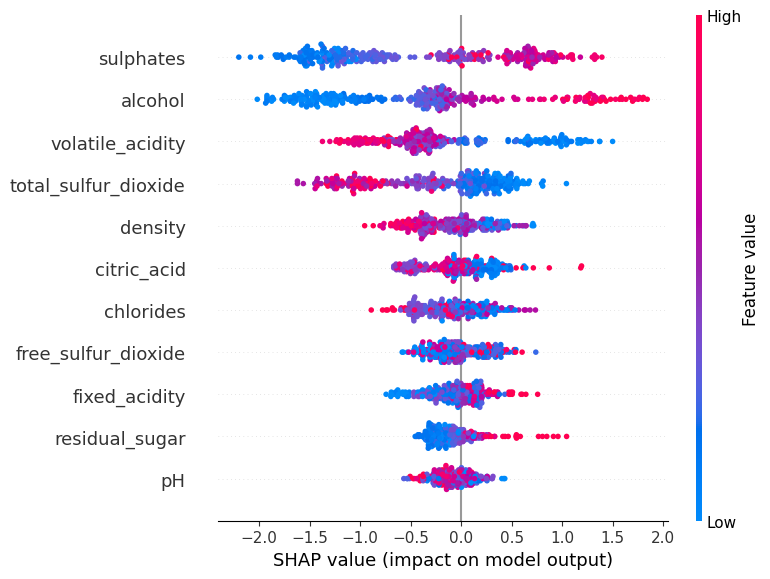

In [287]:
# ---- SHAP interpretation ----
# Initialize the SHAP explainer
explainer = shap.Explainer(xgb_best)
shap_values = explainer(X_test)

# SHAP summary plot (global interpretability)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)


### Interpretations of the SHAP Plot:

1. **Sulphates**:
   - This feature is the most impactful. Higher values of sulphates (red points) tend to increase the model's predictions (positive SHAP values), while lower values (blue points) tend to decrease the predictions (negative SHAP values).

2. **Alcohol**:
   - Alcohol is also highly influential. High alcohol values (red points) push predictions higher, while low values (blue points) reduce the predictions. This aligns with its high importance in the gain and cover plots.

3. **Volatile Acidity**:
   - Lower values of volatile acidity (blue points) have a positive impact on the prediction (i.e., they increase the prediction). In contrast, high values (red points) tend to decrease the prediction, suggesting that lower volatile acidity is associated with higher model output.

4. **Total Sulfur Dioxide**:
   - Instances with lower total sulfur dioxide levels (blue) are associated with positive predictions, while higher levels (red) seem to push the predictions down, although the impact is not as strong as some of the top features.

5. **Density** and **Citric Acid**:
   - These features show more varied effects. For example, high density and citric acid values (red) seem to have mixed impacts, both increasing and decreasing predictions based on context.

6. **Chlorides**, **Free Sulfur Dioxide**, **Fixed Acidity**, **Residual Sugar**, and **pH**:
   - These features show smaller impacts compared to others. However, they still contribute to the model's predictions, with varied SHAP values across the feature value spectrum.

### General Conclusion:
- Features like **sulphates** and **alcohol** strongly influence the model, with clear patterns showing that higher values drive the prediction up.
- Some features, like **volatile acidity**, have an inverse relationship, where low values increase predictions.
- The color gradient provides insights into how different ranges of feature values affect the model. For instance, high sulphates and alcohol content generally lead to higher predictions, while high volatile acidity has the opposite effect.



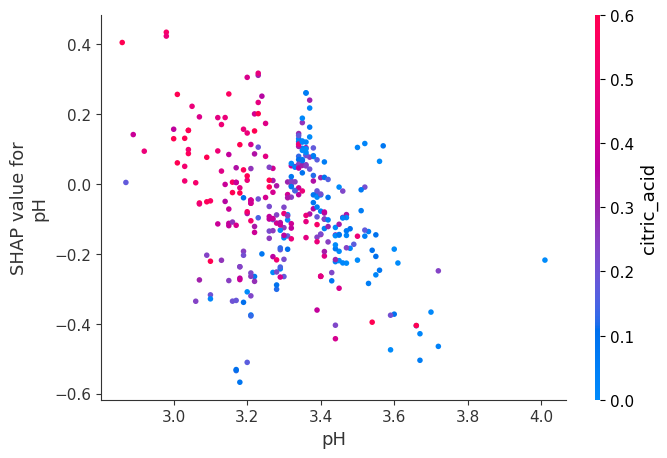

In [288]:
# SHAP dependence plot for a specific feature
# (You can replace 'feature_name' with a column name of your choice from X_test)
shap.dependence_plot("pH", shap_values.values, X_test)

- **X-axis (pH):** The actual pH values in the dataset.
- **Y-axis (SHAP value for pH):** How much the pH value influences the model's output. Positive SHAP values mean the pH increases the prediction, and negative values mean it decreases the prediction.
- **Color scale (citric_acid):** Indicates the value of citric acid for each data point. The color ranges from blue (low citric acid) to red (high citric acid).

### Key observations:
- There is some clustering of points around specific pH values, especially between 3.2 and 3.4, with SHAP values mostly between -0.2 and 0.2.
- Higher citric acid values (red) are more concentrated in the upper right, where SHAP values are positive, suggesting that high pH values combined with high citric acid tend to increase the model's prediction.
- Lower citric acid values (blue) are more spread across the plot, but particularly at lower pH values and lower SHAP values, indicating that lower citric acid and lower pH tend to decrease the model's predictions.



- Use SHAP's `TreeExplainer` to compute feature importance (Shapley values). Do you see any difference with XGBoost's feature importances?
- Produce different plots to analyze Shapley values: 
  - A bar plot that summarizes the mean absolute value of each feature.
  - A beeswarm plot that shows the shapley value for every sample and every feature.
  - A [heatmap plot](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) that indicates how different feature patterns influence the model's output.
- Based on the above results, what makes a wine 'good' or 'bad'?

# WHAT MAKES A GOOD RED WINE BY PERPPLEXITY

A good red wine is characterized by several key attributes that contribute to its overall quality and enjoyment. Here are the main factors to consider:

## Balance
A well-balanced red wine harmonizes its essential components: **acidity, tannins, alcohol, and fruit flavors**. Each element should complement the others without any overpowering characteristics, creating a seamless drinking experience[1][2]. 

## Complexity
Complexity refers to the layers of flavors and aromas that evolve as you taste the wine. A complex red wine often results from various factors like grape variety, terroir, and winemaking techniques. It should provide a multi-dimensional experience with diverse notes that unfold over time[1][2].

## Expression of Fruit
The primary fruit characteristics should be vibrant and clear, reflecting the grape variety used. For instance, Cabernet Sauvignon typically showcases blackcurrant or blackberry notes, while Pinot Noir might present red cherry or raspberry flavors[1][2]. 

## Tannin Integration
Tannins contribute to the structure and texture of red wines. In a good red wine, tannins should be well-integrated, providing a pleasant mouthfeel without being harsh or astringent. This integration also influences the wine's aging potential[1][2].

## Length and Finish
The length of a wine refers to how long its flavors persist on the palate after swallowing. A quality red wine will have a satisfying finish, with lingering flavors that evolve, creating a lasting impression. A short or abrupt finish may indicate lower quality[1][2].

## Additional Characteristics
- **Depth**: Good red wines often have layers of flavor that prevent them from being one-dimensional[2].
- **Character**: A wine's character reflects its unique personality influenced by terroir and grape variety[2].
  
In summary, a good red wine combines balance, complexity, vibrant fruit expression, well-integrated tannins, and a long finish. Personal taste plays a significant role in individual preferences; however, these characteristics generally define quality in red wines[1][2].

Citations:
[1] https://www.grandcruwinefridges.com.au/blogs/articles/what-makes-a-good-red-wine-vs-a-bad-red-wine
[2] https://www.riojamurilloviteri.com/blog/learn-about-wine/5-characteristics-good-red-wine/
[3] https://greatist.com/eat/crash-course-red-wine-for-beginners
[4] https://wineninjas.org/2019/03/01/smoothest-red-wines-for-beginners/
[5] https://ingoodtaste.com/blogs/wine-101/red-wine
[6] https://oeforgood.com/en/pages/plan-couleurs-vins-vin-rouge-faire-son-choix
[7] https://www.goodpairdays.com/guides/wine-101/article/red-wine/
[8] https://winefolk.co.uk/what-is-a-good-red-wine/

In [289]:
# Complete this cell with your code
# Use SHAP's TreeExplainer on the trained XGBoost model
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_train)

In [290]:
# Compute mean absolute SHAP values for each feature
shap_importance = np.abs(shap_values).mean(axis=0)

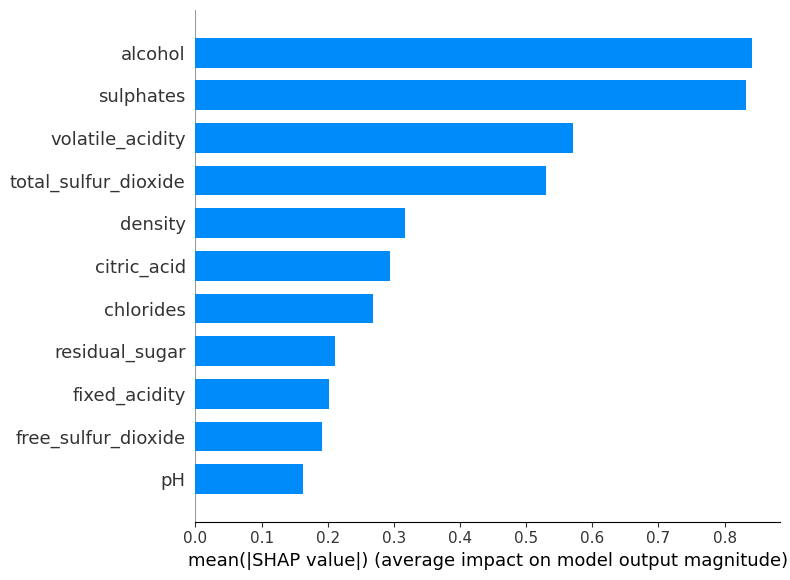

In [291]:
# Plot a SHAP summary plot for overall feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar")

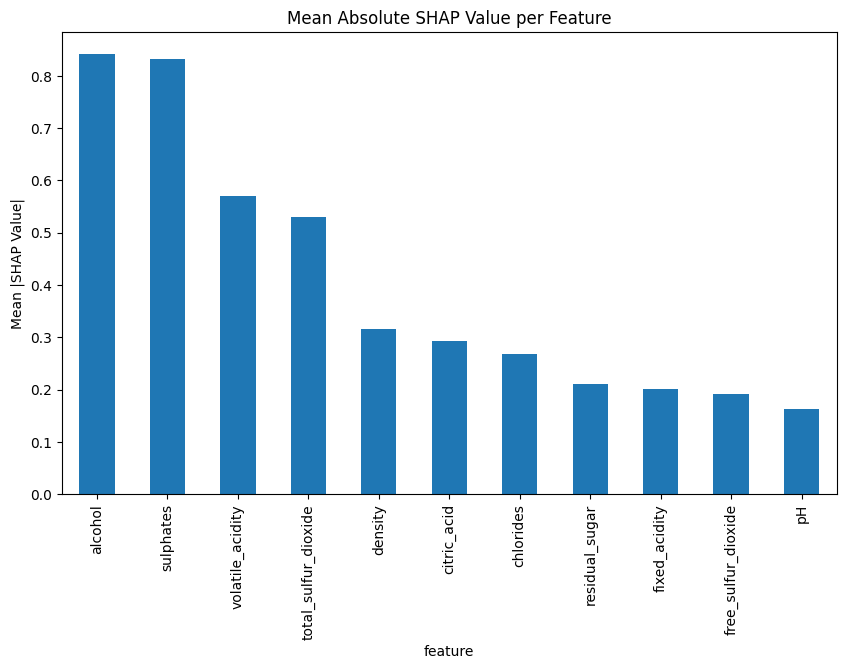

In [292]:
import pandas as pd

# Create a dataframe for feature importances
feature_importance_df = pd.DataFrame(
    {"feature": X_train.columns, "shap_importance": shap_importance}
).sort_values(by="shap_importance", ascending=False)

# Plot the bar plot
feature_importance_df.plot(
    kind="bar", x="feature", y="shap_importance", legend=False, figsize=(10, 6)
)
plt.title("Mean Absolute SHAP Value per Feature")
plt.ylabel("Mean |SHAP Value|")
plt.show()

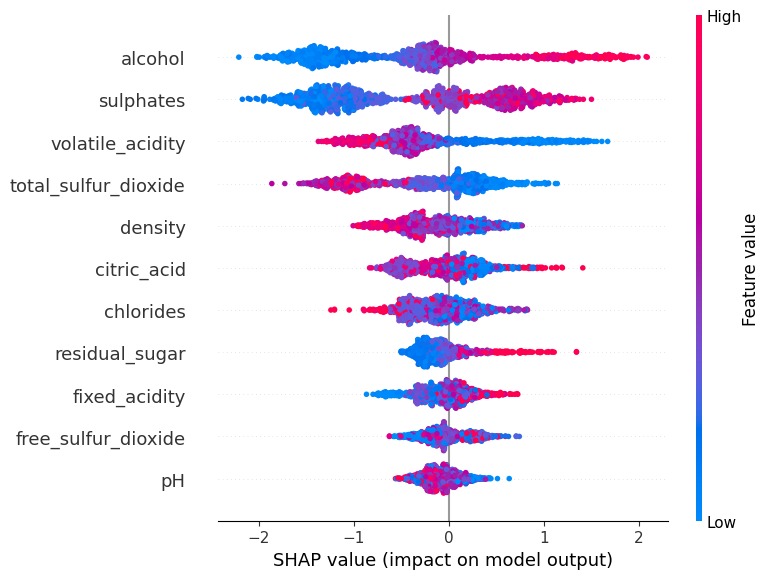

In [293]:
shap.summary_plot(shap_values, X_train)

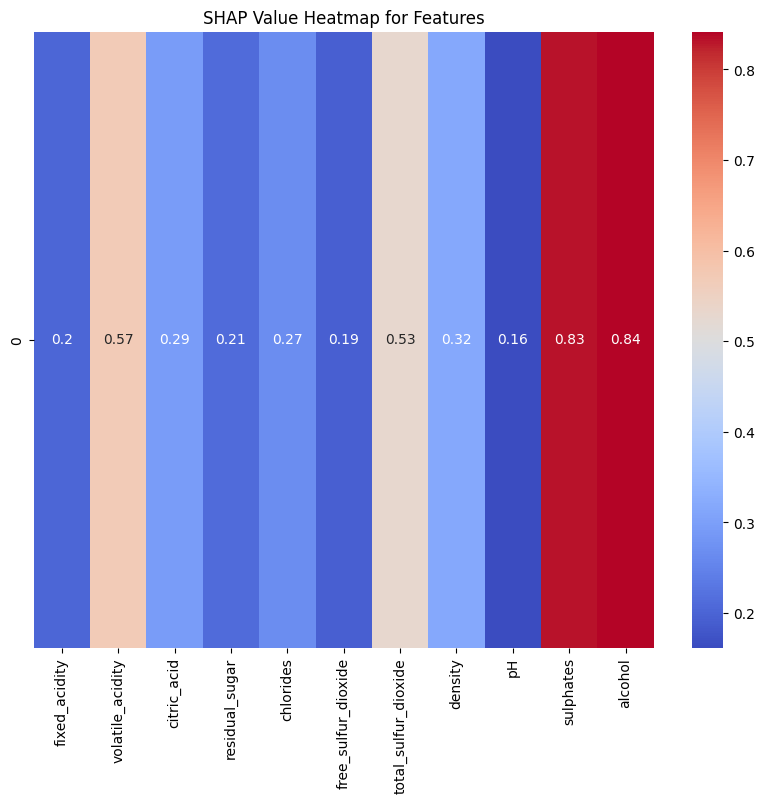

In [294]:
# Assuming shap_values has shape (n_samples, n_features)
# Compute the mean absolute SHAP values across samples for each feature
shap_mean = np.mean(np.abs(shap_values), axis=0)

# Convert to DataFrame for heatmap (assuming X_train is your feature data)
shap_df = pd.DataFrame([shap_mean], columns=X_train.columns)

# Since heatmap expects a square matrix, reshape correctly for interaction
plt.figure(figsize=(10, 8))
sns.heatmap(shap_df, cmap="coolwarm", annot=True)
plt.title("SHAP Value Heatmap for Features")
plt.show()



1. **Alcohol**: Wines with higher alcohol content are more likely to be classified as good, as shown by its high positive SHAP values. This feature has the highest impact on the model's predictions.

2. **Sulphates**: Higher sulphate levels also tend to indicate a good wine. This feature ranks second in importance.

3. **Volatile Acidity**: Lower volatile acidity correlates with a better wine. Wines with high volatile acidity are likely to be classified as bad since it negatively impacts the model’s predictions.

4. **Total Sulfur Dioxide**: This feature has a moderate impact, with higher levels suggesting worse wine quality, but there seems to be a complex relationship based on the second plot, where high and low values both impact the model in different ways.

5. **Density**: Higher density appears to be associated with worse wines. The SHAP plot shows a negative relationship between density and the model’s predictions.

6. **Citric Acid and Chlorides**: These have a less significant impact compared to alcohol and sulphates, but higher citric acid seems to indicate better wine, while higher chlorides indicate worse wine.

7. **Residual Sugar**: This feature has a lower impact overall, but higher residual sugar tends to correspond to lower wine quality.

8. **Fixed Acidity** and **pH**: These have a relatively lower impact on the model, but lower pH (more acidic) and moderate fixed acidity levels may contribute to better wines.

In summary:
- **Good wines** tend to have higher alcohol content, more sulphates, lower volatile acidity, and lower density.
- **Bad wines** tend to have higher volatile acidity, higher density, and lower alcohol content.

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.
- How does that modify your perspective on what makes a good or bad wine?

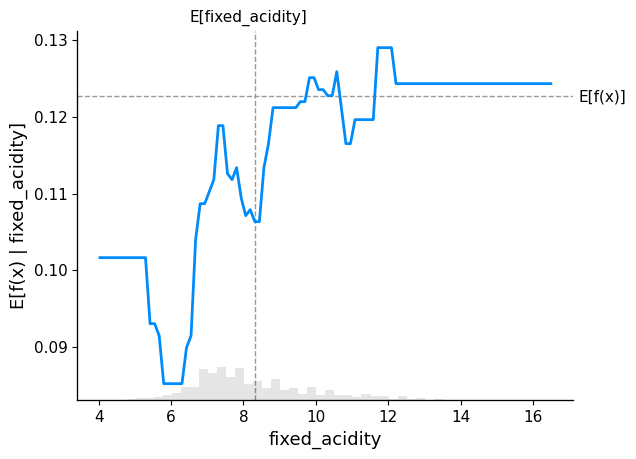

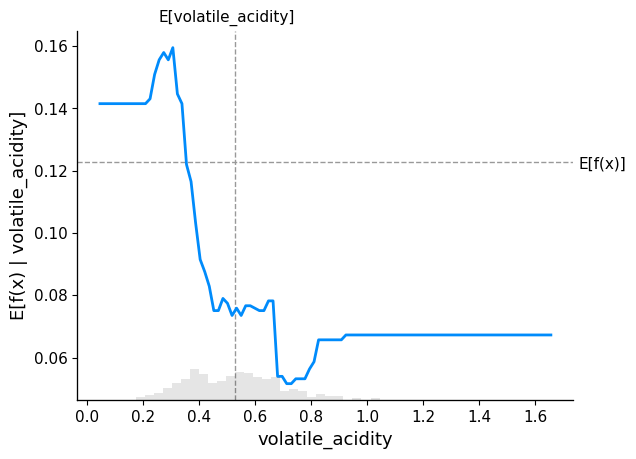

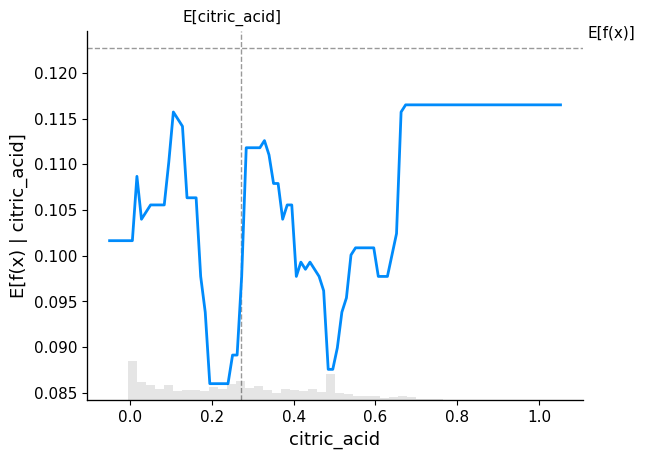

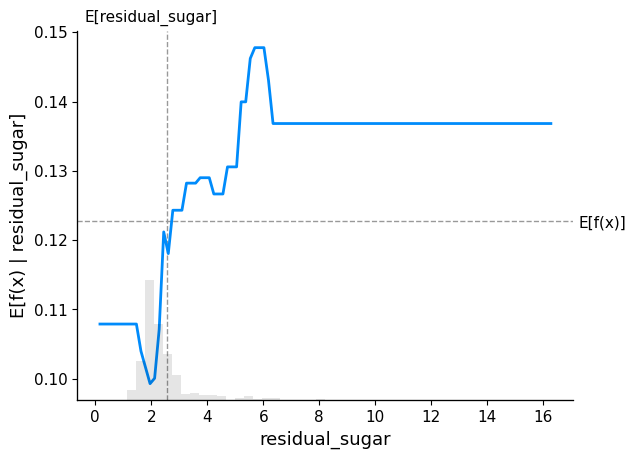

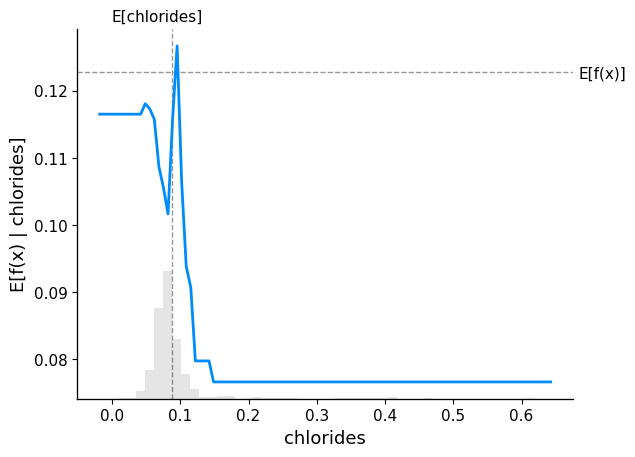

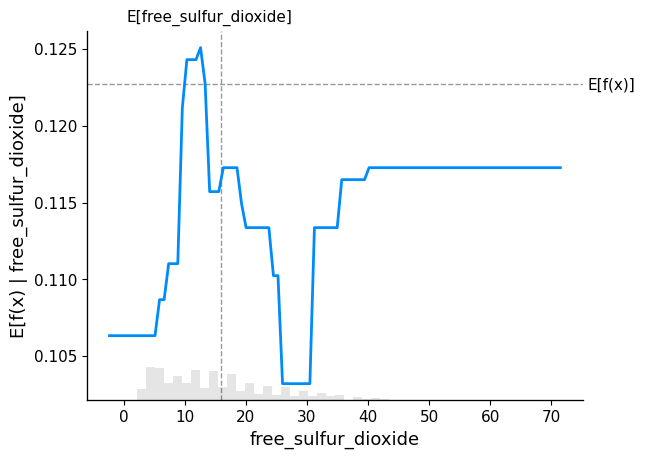

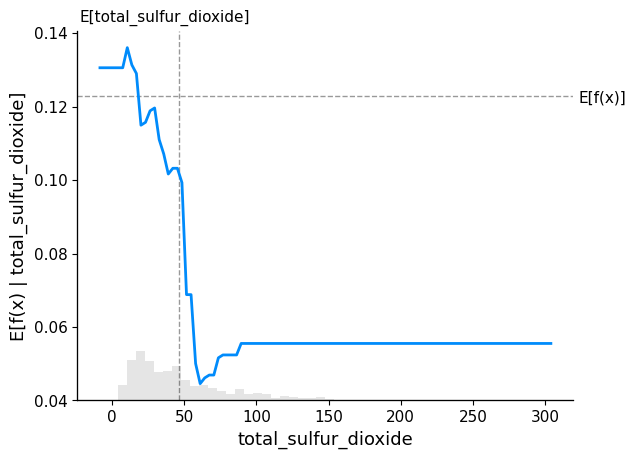

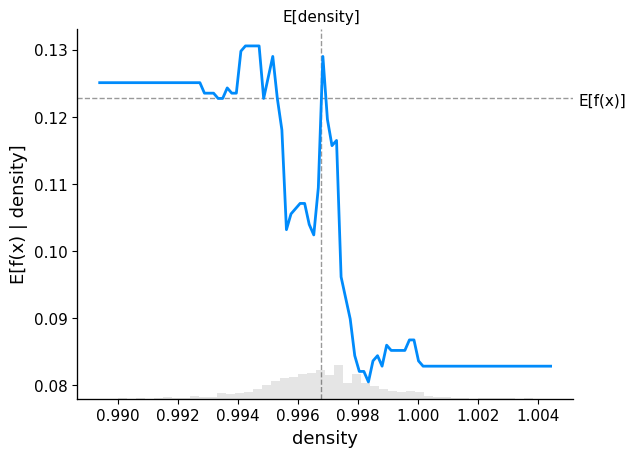

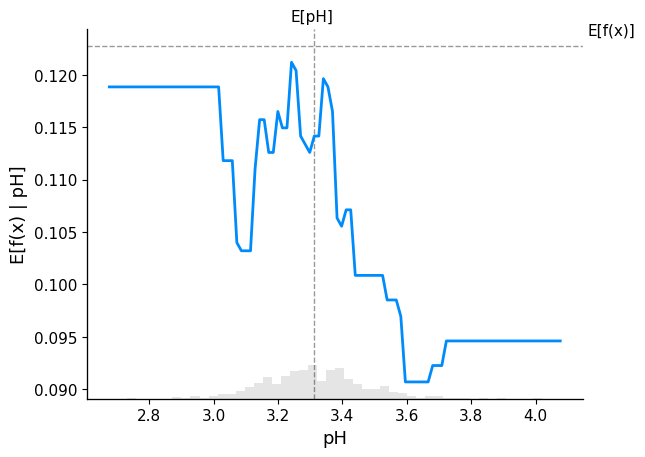

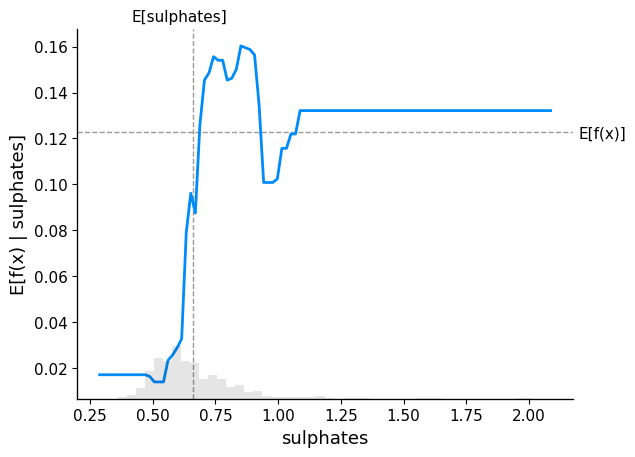

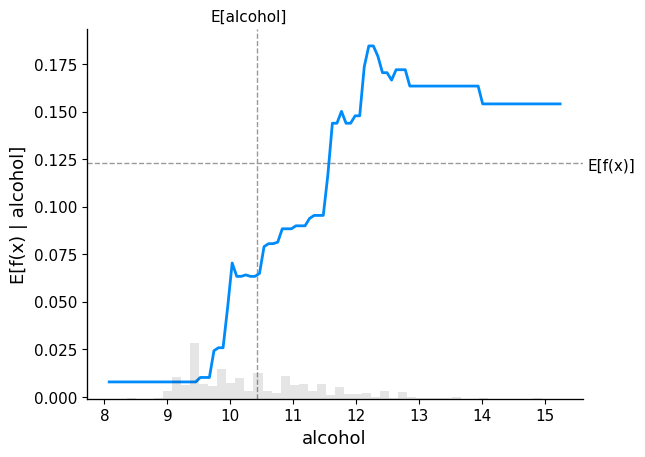

In [295]:
for i in range(11):
    shap.plots.partial_dependence(
        i,
        xgb_best.predict,
        X_train,
        model_expected_value=True,
        feature_expected_value=True,
        ice=False,
    )

## Phenolic Compounds

Phenolic compounds play a crucial role in determining the quality of red wines. They contribute to color, flavor, and mouthfeel.

### Flavonoids
Flavonoids make up over 85% of the phenolic components in red wine[1]. Key flavonoids include:

- **Flavanols**: Catechin and epicatechin are the most important flavanols, responsible for astringency, bitterness, and structure[1].
- **Flavonols**: Compounds like myricetin, quercetin, kaempferol, and rutin impact color, taste, and health properties[1].
- **Anthocyanins**: These are responsible for the red color of wines. Common anthocyanins include delphinidin-3-glucoside, cyanidin-3-glucoside, and malvidin-3-glucoside[1].

### Tannins
Tannins are polymers of flavan-3-ol molecules that contribute to the wine's structure and aging potential[2]. Well-integrated tannins are a sign of good quality red wine.

### Resveratrol
While present in lower concentrations than other polyphenols, resveratrol is a notable compound in red wine due to its potential health benefits[1].

## Acids

The balance of acids is crucial for wine quality. Key acids include:

- **Tartaric acid**: Often added to balance wines from warmer regions[4].
- **Malic acid**: Converted to lactic acid during malolactic fermentation, which can soften harsh wines and add complexity[4].

## Alcohols

Ethanol is the primary alcohol in wine, typically comprising about 12% of red wine[2]. The alcohol content affects the wine's body and can enhance bitterness perception.

## Sugars

While red wines are generally fermented to dryness, residual sugars can impact the wine's balance and perceived quality[4].

## Chemical Indicators of Quality

1. **Balance**: A good red wine shows a harmonious balance between phenolic compounds, acids, and alcohols[5].

2. **Complexity**: Higher concentrations and diversity of phenolic compounds, particularly flavonoids, contribute to a wine's complexity[1][5].

3. **Color stability**: The presence and stability of anthocyanins and their complexes indicate good quality and aging potential[2].

4. **Tannin integration**: Well-polymerized tannins contribute to a smooth mouthfeel rather than harsh astringency[5].

5. **Acid balance**: Proper acid levels contribute to freshness and longevity[4][5].

Poor quality red wines may exhibit:
- Excessive volatile acidity (acetic acid)
- Imbalanced alcohol levels
- Unripe or overripe fruit flavors (related to phenolic compound development)
- Harsh or poorly integrated tannins
- Lack of complexity in phenolic profile

Understanding these chemical components and their interactions provides valuable insights into what makes a good or poor red wine from a scientific perspective.

Citations:
[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4973766/
[2] https://www.compoundchem.com/2014/05/28/redwinechemicals/
[3] https://en.wikipedia.org/wiki/Wine_chemistry
[4] https://ingoodtaste.com/blogs/wine-101/red-wine
[5] https://www.grandcruwinefridges.com.au/blogs/articles/what-makes-a-good-red-wine-vs-a-bad-red-wine
[6] https://www.riojamurilloviteri.com/blog/learn-about-wine/5-characteristics-good-red-wine/
[7] https://www.guildsomm.com/public_content/features/articles/b/jamie_goode/posts/wine-flavour-chemistry
[8] https://oeforgood.com/en/pages/plan-couleurs-vins-vin-rouge-faire-son-choix

### Analyze a few bad wines, and try to see how to make them better

Pick some of the worst wines, and try to see what make them so bad. Check out [`shap.plots.heatmap`](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) for some visual tool to do this.

How would you go about improving them?

In [313]:
# Complete this cell with your code
worst_wines_idx = np.where(y_train == 0)[0]

In [314]:
shap_values_worst = explainer.shap_values(X_train.iloc[worst_wines_idx])

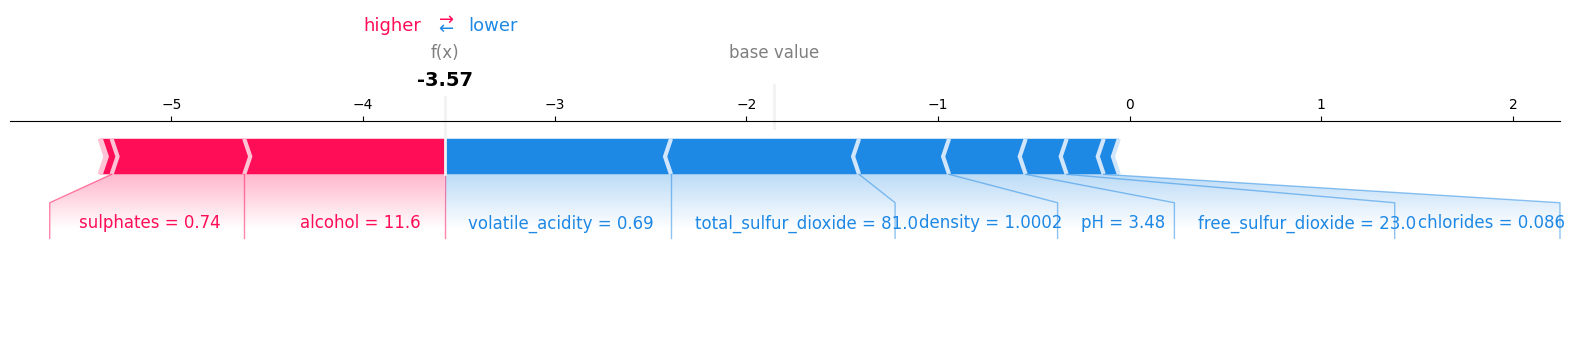

In [315]:
# Generate SHAP values for those samples
shap_values_worst = explainer.shap_values(X_train.iloc[worst_wines_idx])

# Plot the force plot for one of the worst wines
shap.force_plot(
    explainer.expected_value,
    shap_values_worst[0],  # SHAP values for a specific sample
    X_train.iloc[worst_wines_idx].iloc[0],  # Corresponding feature values for that wine
    matplotlib=True,
)

### Key Components:
- **The horizontal axis**: Represents the model's predicted output for this specific instance, with the base value as the starting point. The base value is the average model output over the dataset, and the prediction for this instance is shown as \( f(x) = -3.57 \).
  
- **Red (pushes higher)**: Features in red contribute to increasing the prediction value. In this case:
  - **Alcohol = 11.6** and **Sulphates = 0.74** are pushing the prediction higher (closer to 0).
  
- **Blue (pushes lower)**: Features in blue contribute to decreasing the prediction value. In this case:
  - **Volatile acidity = 0.69**, **Total sulfur dioxide = 81.0**, **Density = 1.0002**, **pH = 3.48**, **Free sulfur dioxide = 23.0**, and **Chlorides = 0.086** all push the prediction lower (toward -3.57).

### Base Value and Prediction:
- **Base value**: The model starts at a base value (average model prediction across the dataset). From there, each feature pushes the prediction up or down.
  
- **Prediction (-3.57)**: The final output for this instance is -3.57. The red and blue segments show how much each feature contributed to this output.

### Observations:
1. **Alcohol and Sulphates**: These two features have positive SHAP values and are the most important in pushing the prediction toward a higher value.
2. **Volatile Acidity and Total Sulfur Dioxide**: These features have negative SHAP values, meaning they pull the prediction lower.
3. **Overall Influence**: Despite a few positive influences (alcohol and sulphates), the negative impact from features like volatile acidity, total sulfur dioxide, and density has resulted in a negative prediction of -3.57.



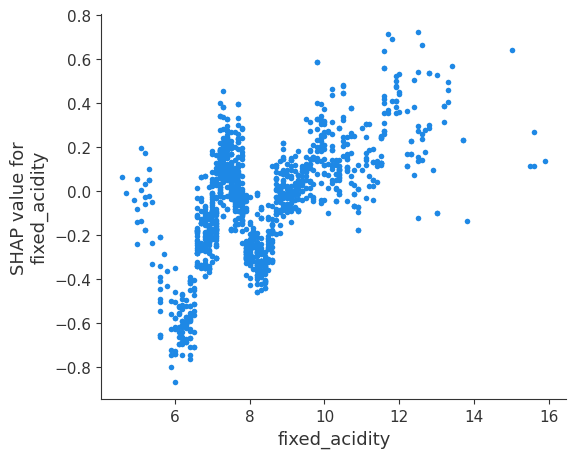

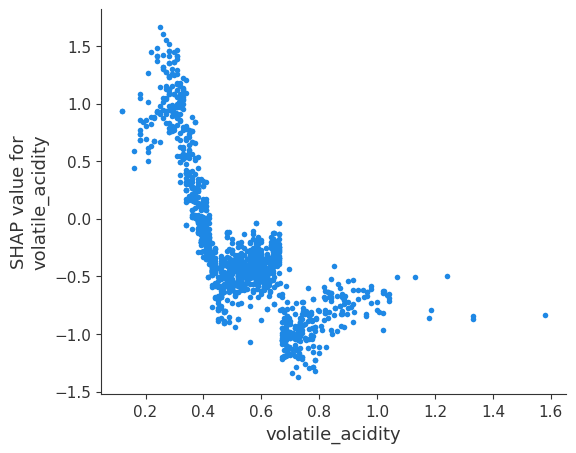

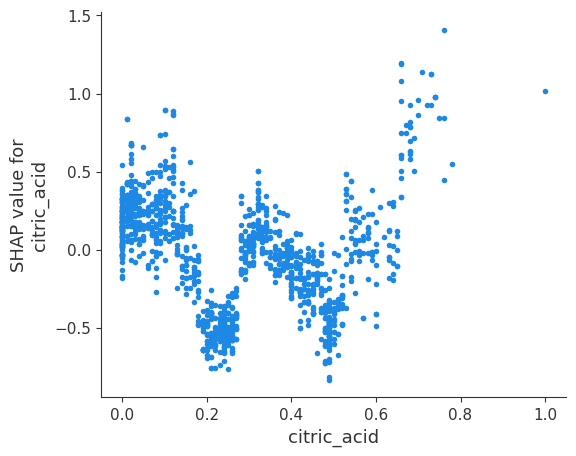

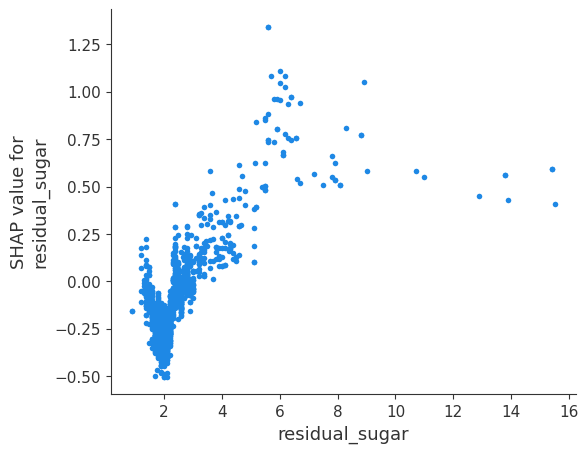

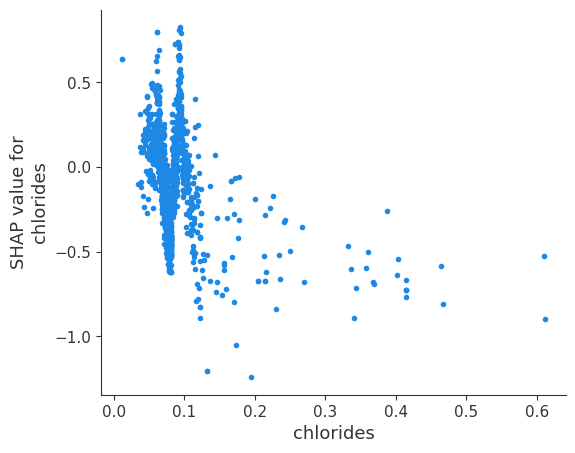

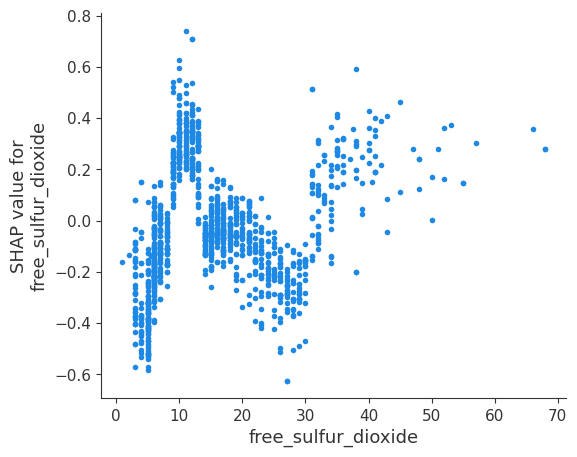

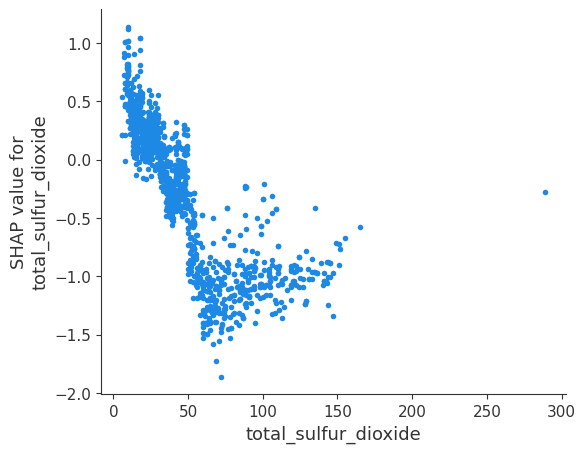

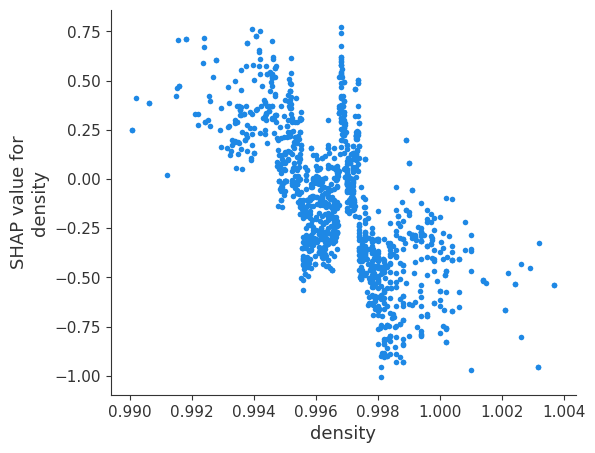

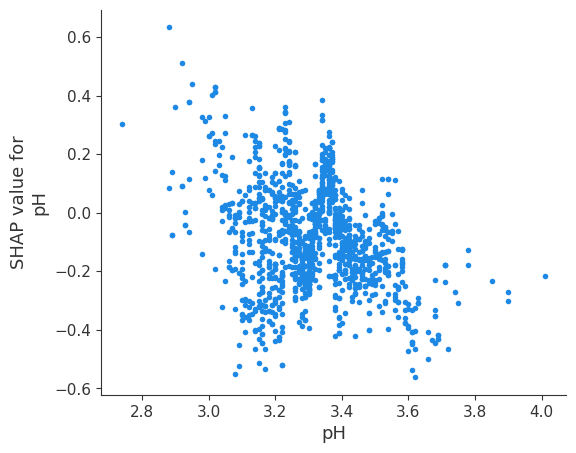

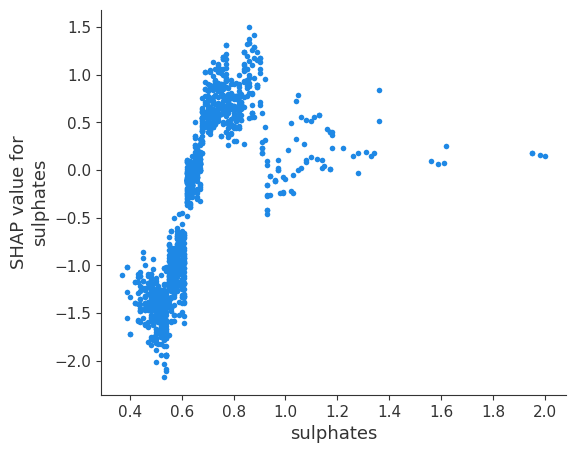

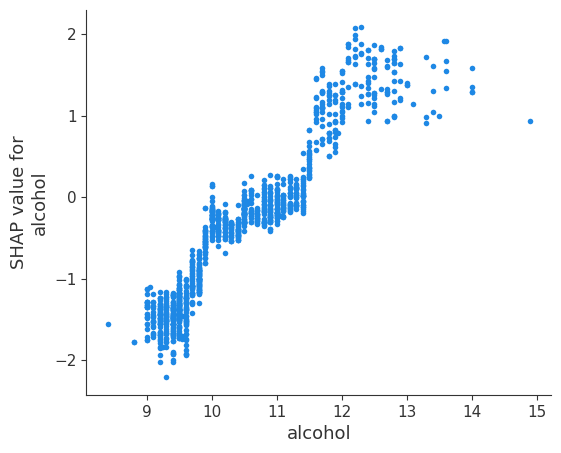

In [298]:
# Plot a SHAP dependence plot for the 'alcohol' feature
for i in range(11):
    shap.dependence_plot(
        i,
        shap_values,
        X_train,
        interaction_index=None,  # Optionally, specify a feature for interaction
    )

### Interpretation:
- **X-axis**: Represents the actual values of the "alcohol" feature in the dataset.
- **Y-axis**: Represents the SHAP values, which indicate the impact of the "alcohol" feature on the model's output. Positive SHAP values mean the feature pushes the model's prediction higher, while negative SHAP values push it lower.

### Key Observations:
1. **Positive Correlation**: The SHAP values increase as the alcohol content increases, meaning higher alcohol content positively contributes to the model's prediction. This suggests that higher alcohol levels are associated with a higher prediction from the model.
   
2. **Low Alcohol Impact**: For low alcohol values (around 9-10), SHAP values are mostly negative, meaning that lower alcohol levels decrease the model's prediction.

3. **Higher Alcohol Impact**: As the alcohol content exceeds around 12, the SHAP values become more positive, indicating that higher alcohol values strongly influence the model in the positive direction.

# Wrap-up and conclusion

As wrap-up, explain what are your key findings, and make 3 recommendations to the wine maker on how to improve the wines for next year. How confident are you that making these changes will lead to better wines? Explain in simple terms to the winemaker the limitations of your approach in terms of capturing causality.

**Key Findings:**

1. **Alcohol and Sulfates Content:** Higher alcohol and sulfates levels tend to be associated with better wine quality. However, this doesn't mean more is always better—balance is still key.
2. **Volatile Acidity:** Wines with lower volatile acidity are generally perceived as higher quality. High volatile acidity, on the other hand, negatively impacts taste and aroma.
3. **Total Sulfur Dioxide:** While sulfur dioxide levels do affect wine quality, the relationship is more complex. Excess sulfur can result in off-flavors, but moderate amounts are necessary to preserve the wine.

**Recommendations for Next Year:**

1. **Increase Alcohol and Sulfate Content Carefully:** Slightly increasing the alcohol content while ensuring a balanced sulfates level may enhance the wine’s robustness and mouthfeel. Be careful not to overdo it, as this could lead to harsh or overpowering flavors.
   
2. **Reduce Volatile Acidity:** Focus on managing fermentation processes and choosing cleaner, more stable yeast strains to reduce volatile acidity. This will improve the overall quality and aroma of the wine.

3. **Moderate Sulfur Dioxide Levels:** Maintain sulfur dioxide at levels that preserve the wine but avoid going too high. Consider fine-tuning sulfur dioxide usage based on different phases of production to optimize both preservation and flavor.

**Confidence in Recommendations:**
I’m fairly confident that these changes, if properly implemented, will lead to improvements in wine quality. However, the relationship between chemical components and taste is not linear, and it varies based on a number of factors like grape variety, climate, and winemaking techniques. Therefore, while these adjustments are based on known trends, some trial and experimentation will be necessary.

**Limitations of the Approach:**
The findings focus mainly on correlations between chemical components and wine quality, but correlation doesn’t always imply direct causality. For instance, increasing alcohol content may not improve taste if other variables, like fruit concentration or aging, are neglected. Similarly, reducing volatile acidity may help, but factors such as barrel aging or fermentation conditions could also be important. In simple terms, these recommendations are based on general patterns, but each vineyard's unique conditions mean that you’ll need to adjust and refine based on your own experimentation.
